# Programmentwurf Künstliche Intelligenz

## Thema :  Evidenztheorie und Case Based Reasoning

### Namen der Studierenden: 

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Einlesen der CSV-Datei
file_path = 'bikedata/sampled_data_001.csv'   # Einsetzen!
data = pd.read_csv(
    file_path,
    sep=";",
    decimal=",",
    keep_default_na=True,
    na_values=["", " ", "NA", "NaN", "nan", "None", None]
)

# Robust: Spaltennamen und Stringwerte trimmen
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].str.strip()
    data[col] = data[col].replace({"": pd.NA})

# Robuste Numerik-Konvertierung für bekannte numerische Spalten (Fehlerhafte Strings -> NaN)
num_cols_expected = ['Distance', 'Elevation Gain', 'Moving Time', 'Average Speed']
for col in [c for c in num_cols_expected if c in data.columns]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Kernmetriken bereinigen: NaNs entfernen und grobe Ausreißer kappen
key_cols = ['Distance', 'Elevation Gain']
initial_rows = len(data)
data = data.dropna(subset=key_cols)
if len(data) < initial_rows:
    print(f'Removed {initial_rows - len(data)} rows ohne Distance/Elevation.')

for col in key_cols:
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    before = len(data)
    data = data[(data[col] >= q_low) & (data[col] <= q_high)]
    print(f'{col}: gekappt auf 1%-99% (Entfernt {before - len(data)} Ausreißer).')

# Einfache Qualitätsprüfung
print('Dataset shape nach Bereinigung:', data.shape)
print('Info:')
print(data.info())
print('NaN pro Spalte:')
print(data.isna().sum().sort_values(ascending=False).to_string())

# Slope vorbereiten (Gradient)
mask = (data['Distance'] > 0)
if mask.any():
    data.loc[mask, 'Slope'] = data.loc[mask, 'Elevation Gain'] / data.loc[mask, 'Distance']

# Optional: Label-Verteilung (falls vorhanden)
if 'Bike Type' in data.columns:
    allowed = ['race bike', 'mtb', 'trecking bike']
    bt = data['Bike Type'].astype('string').str.strip().str.lower()
    bt = bt.replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
    unknown = sorted(set(bt.dropna().unique()) - set(allowed))
    if unknown:
        print('Warnung: Unerwartete Labels in Bike Type:', unknown)
    data['Bike Type'] = pd.Categorical(bt, categories=allowed)

    # Übersicht
    print('Label-Verteilung (Bike Type) inkl. NaN:')
    print(data['Bike Type'].value_counts(dropna=False))
    labeled = int(data['Bike Type'].notna().sum())
    unlabeled = int(data['Bike Type'].isna().sum())
    print(f'Gelabelt: {labeled} | Unlabeled: {unlabeled} ({unlabeled/(labeled+unlabeled):.1%})')


Distance: gekappt auf 1%-99% (Entfernt 6 Ausreißer).
Elevation Gain: gekappt auf 1%-99% (Entfernt 6 Ausreißer).
Dataset shape nach Bereinigung: (235, 7)
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 1 to 246
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        235 non-null    float64
 1   Moving Time     235 non-null    int64  
 2   Elevation Gain  235 non-null    float64
 3   Time            235 non-null    object 
 4   Month           235 non-null    int64  
 5   Day             235 non-null    int64  
 6   Bike Type       183 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 14.7+ KB
None
NaN pro Spalte:
Bike Type         52
Distance           0
Moving Time        0
Elevation Gain     0
Time               0
Month              0
Day                0
Label-Verteilung (Bike Type) inkl. NaN:
Bike Type
race bike        101
trecking bike     60
NaN           

#### Etwas Analyse vorab ... gerne erweitern

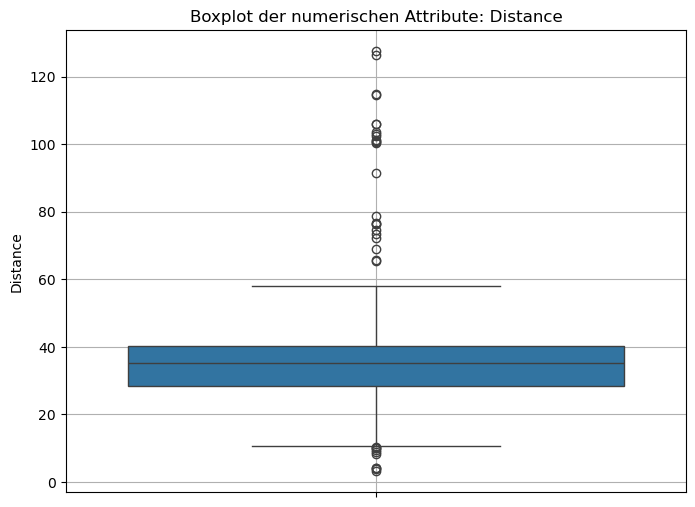

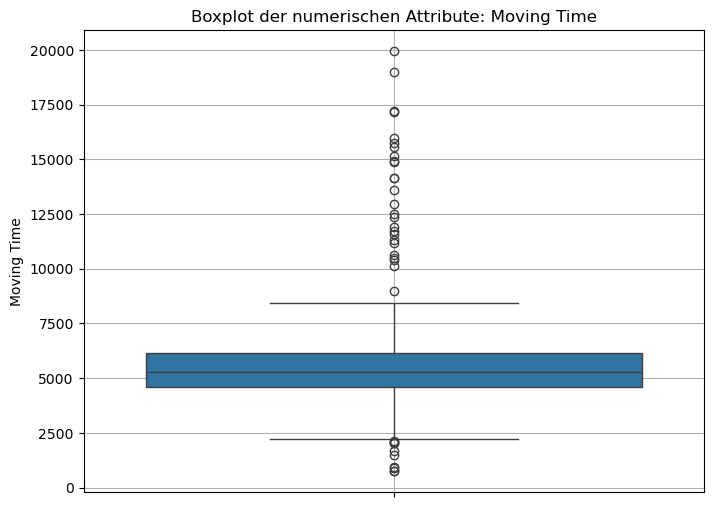

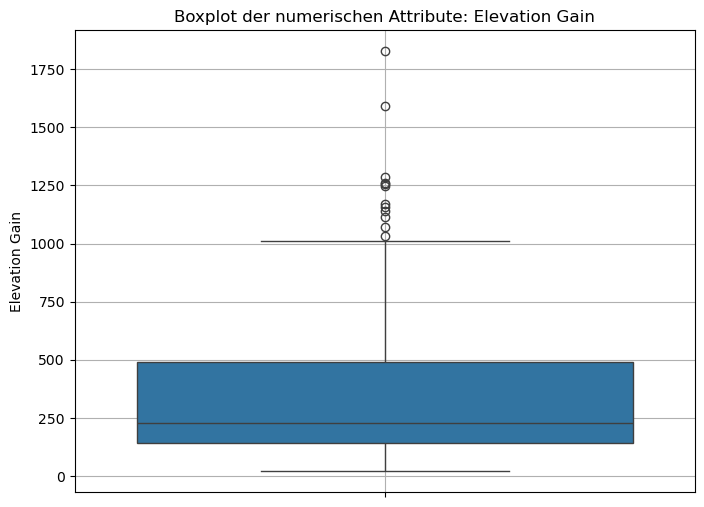

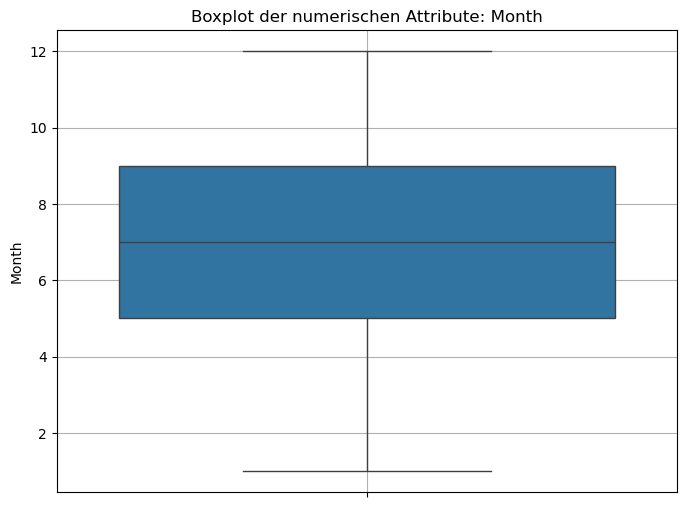

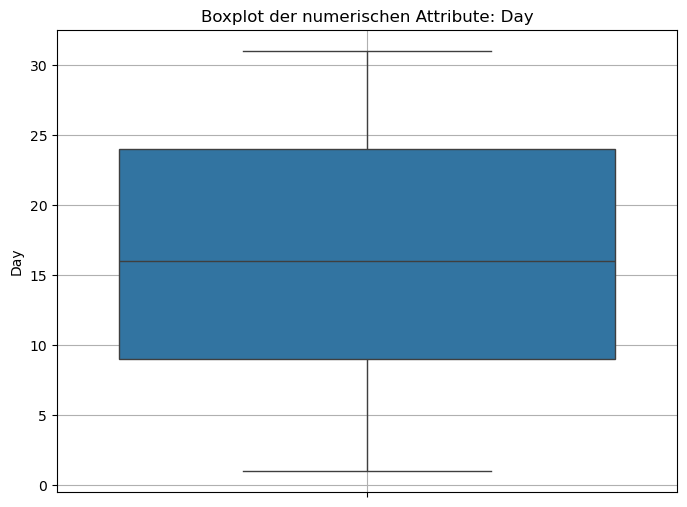

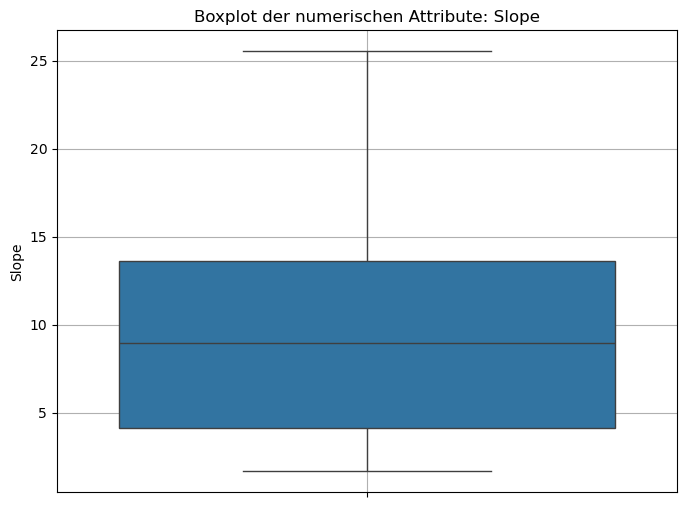

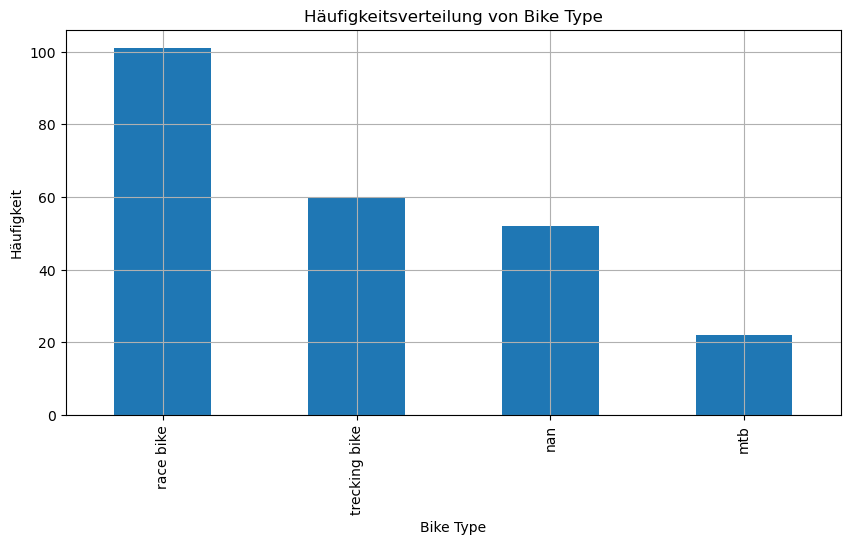

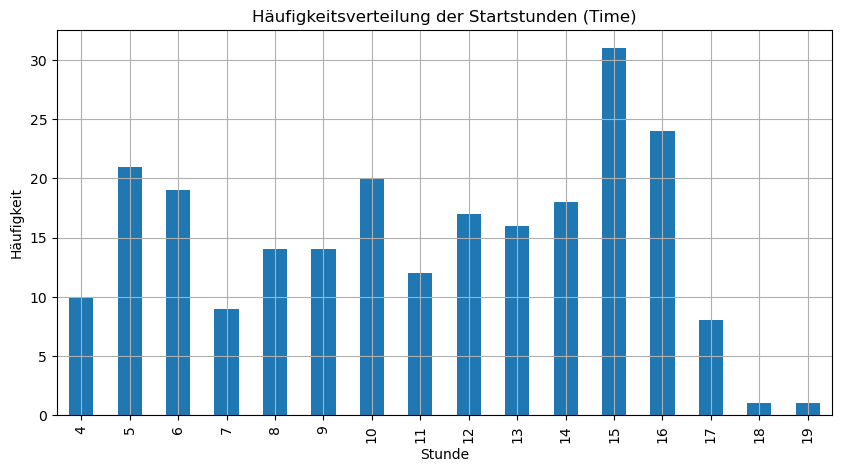

In [2]:
# Numerische Attribute - Boxplots für stetige Variablen
numeric_columns = data.select_dtypes(include='number').columns
continuous_columns = [col for col in numeric_columns if data[col].nunique(dropna=True) > 10]
discrete_numeric_columns = [col for col in numeric_columns if col not in continuous_columns]

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attribute: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# Diskrete numerische Attribute - Häufigkeitsverteilungen
for column in discrete_numeric_columns:
    counts = data[column].value_counts(dropna=False).sort_index()
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != 'Time']

for column in categorical_columns:
    counts = data[column].value_counts(dropna=False)
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Zeit als Tagesstunde aggregieren
if 'Time' in data.columns:
    time_hours = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour.dropna()
    if not time_hours.empty:
        counts = time_hours.value_counts().sort_index()
        plt.figure(figsize=(10, 5))
        counts.plot(kind='bar')
        plt.title('Häufigkeitsverteilung der Startstunden (Time)')
        plt.xlabel('Stunde')
        plt.ylabel('Häufigkeit')
        plt.grid(True)
        plt.show()


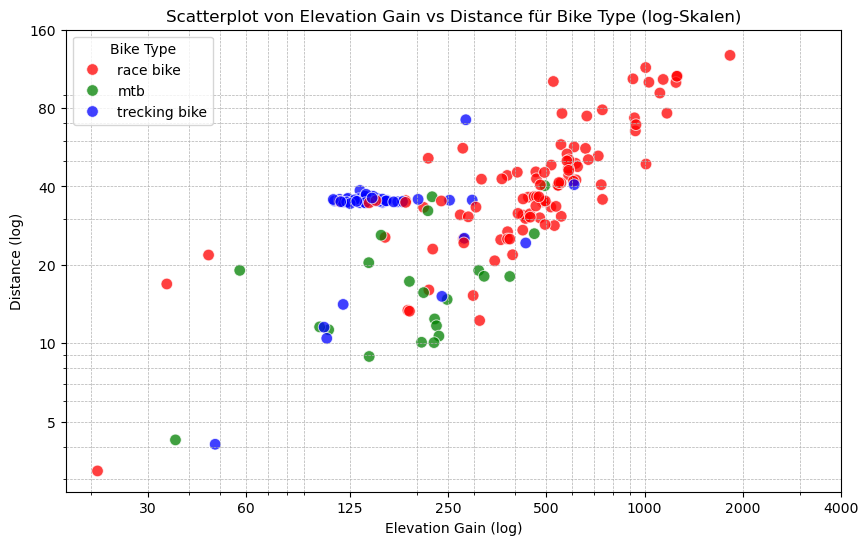

In [3]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type
plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'blue'}
sns.scatterplot(
    data=data,
    x='Elevation Gain',
    y='Distance',
    hue='Bike Type',
    palette=colors,
    alpha=0.75,
    s=70
)
plt.xscale('log')
plt.yscale('log')
distance_ticks = [5, 10, 20, 40, 80, 160]
elevation_ticks = [30, 60, 125, 250, 500, 1000, 2000, 4000]
plt.yticks(distance_ticks, [str(t) for t in distance_ticks])
plt.xticks(elevation_ticks, [str(t) for t in elevation_ticks])
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type (log-Skalen)')
plt.xlabel('Elevation Gain (log)')
plt.ylabel('Distance (log)')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.show()


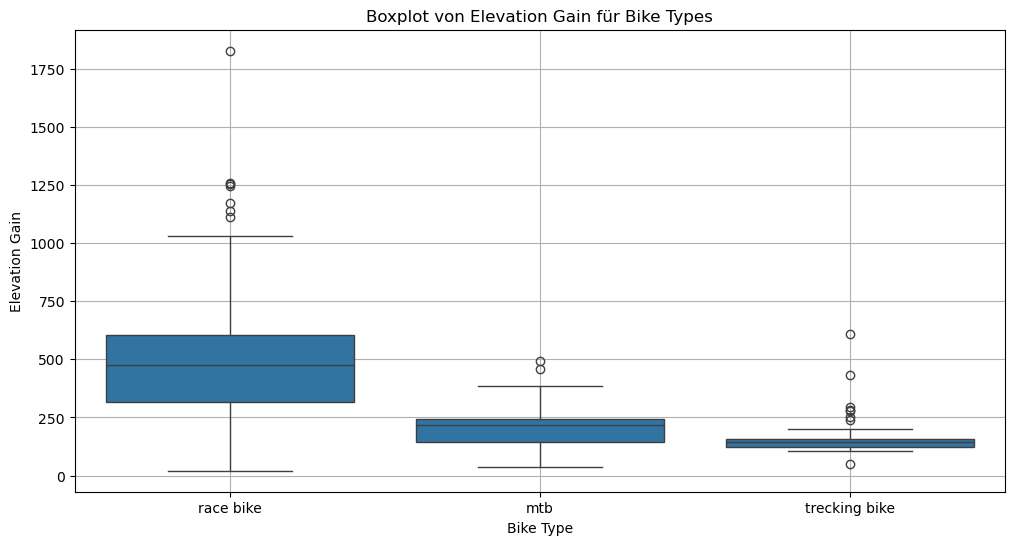

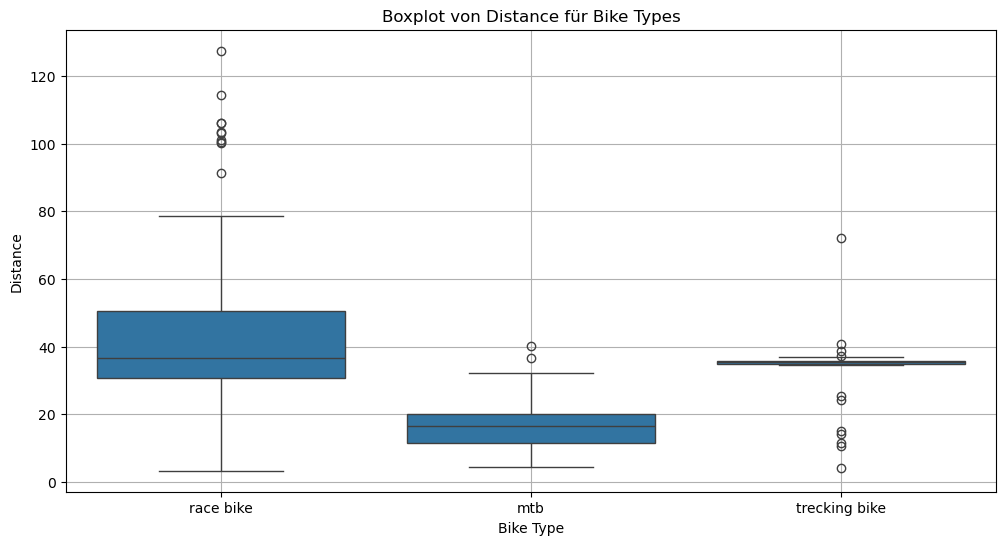

In [4]:
# Boxplots für Elevation Gain und Distance

# Boxplot für Elevation Gain
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Elevation Gain', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Elevation Gain für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Elevation Gain')
plt.grid(True)
plt.show()

# Boxplot für Distance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Distance', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Distance für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

### Distanz vs. Höhenmeter – Regressionslinien je Klasse

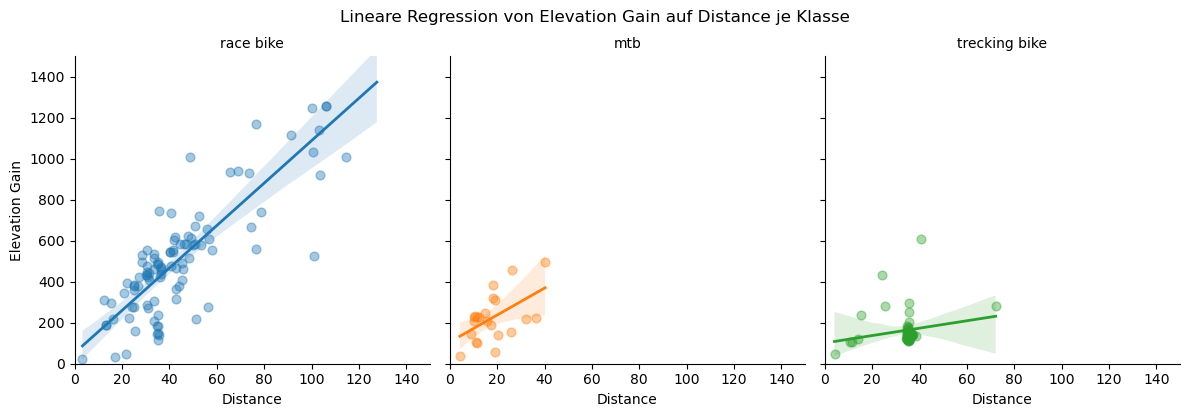

In [5]:
df_reg = data[data['Bike Type'].notna() & (data['Bike Type'] != '')][['Distance','Elevation Gain','Bike Type']].dropna()
if df_reg.empty:
    print('Keine gelabelten Daten für die Regression verfügbar.')
else:
    g = sns.lmplot(
        data=df_reg,
        x='Distance',
        y='Elevation Gain',
        col='Bike Type',
        hue='Bike Type',
        col_wrap=3,
        height=4,
        scatter_kws={'alpha':0.4, 's':40},
        line_kws={'linewidth':2}
    )
    limits = {
        'race bike': ((0, 175), (0, 1600)),
        'mtb': ((0, 60), (0, 600)),
        'trecking bike': ((0, 150), (0, 1500))
    }
    for ax in g.axes.flatten():
        title = ax.get_title()
        for key, lim in limits.items():
            if key in title:
                ax.set_xlim(*lim[0])
                ax.set_ylim(*lim[1])
                break
    g.set_titles('{col_name}')
    g.figure.suptitle('Lineare Regression von Elevation Gain auf Distance je Klasse', y=1.03)
    plt.show()


## Aufgabenteil 1: Evidenztheorie

Entwerfen Sie ein KI Modell auf Basis von Evidenztheorie und setzen Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Fuzzy Mengen zur Bewertung und Integration der Evidenzwerte.


In [6]:
# !pip install py_dempster_shafer

from pyds import MassFunction

# Klassen (Bikes) als Einzelzeichen: r=race bike, m=mtb, t=trecking bike
CLASSES = ['r','m','t']
omega = 'rmt'  # Omega = Gesamtraum


### 1. Daten vorverarbeiten

Wir bereiten den Datensatz so auf, dass er direkt für fuzzy-basierte Evidenz kombiniert werden kann.
- Numerische Spalten (`Distance`, `Elevation Gain`) konvertieren wir in Floats und entfernen fehlerhafte Einträge.
- Kategoriale Felder werden getrimmt (z. B. Bike-Typen) und NaNs sauber behandelt.
- Für die Fuzzy-Definition orientieren wir uns an quantilbasierten Grenzen, damit sich die Mengen an die beobachteten Verteilungen anpassen.


In [7]:
# (Baseline: Fuzzy-Funktionen über Mittelwert ±10 %)
def analyze_feature(series):
    s = series.astype(float)
    s = s[np.isfinite(s)]
    if s.size == 0:
        raise ValueError('Leere Serie für Fuzzy-Analyse')

    mean_v = float(np.nanmean(s))
    min_v = float(np.nanmin(s))
    max_v = float(np.nanmax(s))
    tol = (max_v - min_v) * 0.10

    def safe_div(num, denom):
        return num / denom if denom != 0 else 0.0

    def low(x):
        if x <= mean_v:
            return max(0.0, safe_div(mean_v - x, mean_v - min_v)) if mean_v > min_v else 0.0
        return 0.0

    def high(x):
        if x >= mean_v:
            return max(0.0, safe_div(x - mean_v, max_v - mean_v)) if max_v > mean_v else 0.0
        return 0.0

    def medium(x):
        if (mean_v - tol) <= x <= mean_v:
            return max(0.0, safe_div(x - (mean_v - tol), tol)) if tol > 0 else 0.0
        if mean_v < x <= (mean_v + tol):
            return max(0.0, safe_div((mean_v + tol) - x, tol)) if tol > 0 else 0.0
        return 0.0

    stats = {
        'min': min_v,
        'mean': mean_v,
        'max': max_v,
        'tol': tol
    }
    return low, medium, high, stats

# Fuzzy-Funktionen für Distance, Elevation Gain und Steigung (Baseline)
dist_low, dist_med, dist_high, dist_stats = analyze_feature(data['Distance'])
elev_low, elev_med, elev_high, elev_stats = analyze_feature(data['Elevation Gain'])
if 'Slope' in data.columns:
    slope_low, slope_med, slope_high, slope_stats = analyze_feature(data['Slope'].replace([np.inf, -np.inf], np.nan).dropna())
else:
    slope_low = slope_med = slope_high = lambda x: 0.0
    slope_stats = {}

# Hilfsfunktion: beste Kategorie und Zugehörigkeitsgrad
def best_category(funcs, x):
    vals = {name: max(0.0, min(1.0, f(float(x)))) for name, f in funcs.items()}
    cat = max(vals, key=vals.get)
    return cat, vals[cat], vals


### Begründung zur Wahl der Fuzzy Mengen

- Baseline: Wir starten mit den stückweise linearen Fuzzy-Mengen aus dem Labor (low / medium / high) rund um den Mittelwert ±10 %. Das liefert eine leicht verständliche Einteilung, die ohne zusätzliche Hyperparameter auskommt.
- Datenbasis: Die Voranalyse zeigt, dass Rennrad tendenziell längere Strecken/Höhenmeter aufweist, MTB eher kurze Strecken mit mittleren Höhenmetern fährt und Trekking im unteren Höhenmeterbereich bleibt. Die initialen Mengen sind breit angelegt, um diese Cluster grob abzudecken und Konflikte über Ω abzubilden.
- Evidenzableitung: Pro Merkmal wählen wir Winner-takes-all und geben einen Anteil α=0.8 auf das Singleton, den Rest auf Ω. So bleibt die Unsicherheit explizit modelliert.
- Weiteres Tuning: In späteren Zellen schärfen wir die quantilbasierten Grenzen nach (früheres `dist_high`, schmaleres `elev_medium`) und prüfen via Fehlklassifikationsanalyse/Ω-Plot, wie sich diese Anpassungen auswirken.
- Alternativen: Trapez- oder quantilbasierte Mengen (siehe Tuning-Abschnitt), Soft-Voting über alle Zugehörigkeiten oder zusätzliche Merkmale als separate Evidenzquellen.


### 2. Daten mit Evidenztheorie verarbeiten

Zusammenführen der Daten durch Akkumulation (Dempsters Regel).

In [8]:
# Evidenz aus Fuzzy-Kategorien ableiten und per Dempster kombinieren (vgl. Übungsblatt)

# Mapping der Fuzzy-Kategorien auf Klassen-Buchstaben
dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}
slope_to_cls = {'low': 't', 'medium': 'r', 'high': 'm'}
CLASSES = ['r', 'm', 't']

alpha = 0.8
alpha_dist = alpha
alpha_elev = alpha
alpha_slope = alpha
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}

preds = []
masses = []
for idx_row, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
        s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
    except Exception:
        preds.append(None)
        masses.append(None)
        continue

    cat_d, mu_d, _ = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
    cat_e, mu_e, _ = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha_dist * mu_d, omega: 1 - alpha_dist * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha_elev * mu_e, omega: 1 - alpha_elev * mu_e})
    combined = m1 & m2

    if s is not None and np.isfinite(s):
        cat_s, mu_s, _ = best_category({'low': slope_low, 'medium': slope_med, 'high': slope_high}, s)
        m3 = MassFunction({slope_to_cls[cat_s]: alpha_slope * mu_s, omega: 1 - alpha_slope * mu_s})
        combined = combined & m3

    scores = {c: (combined[c] if c in combined else 0.0) for c in CLASSES}
    best_cls = max(scores, key=scores.get)
    preds.append(label_map[best_cls])
    masses.append(combined)

data['Pred_DS'] = preds
masses = masses


### Begründungen

- Evidenzquellen: Wir nutzen zwei weitgehend unabhängige Merkmale (`Distance`, `Elevation Gain`) als getrennte Evidenzquellen – konsistent mit der Annahme schwacher Unabhängigkeit in Dempster–Shafer.
- Von Fuzzy zu Evidenz: Pro Merkmal wird per Winner-takes-all die stärkste Kategorie gewählt; deren Zugehörigkeit μ bildet die Vertrauensstärke der Evidenz. So entsteht je Merkmal ein einfaches Basismaß mit Singleton und Ω.
- Ω (Ignoranz): Ein Anteil 1−α (hier 0.2) geht auf Ω, um Überkonfidenz zu vermeiden und Unsicherheit (Überlappungen/Schwankungen) explizit zu modellieren.
- Dempsters Regel: Die Kombination verdichtet übereinstimmende Evidenzen und dämpft widersprüchliche durch den Konfliktterm K (Normierung über 1−K). Hoher Konflikt führt zu höherer Masse auf Ω.
- Entscheidungsregel: Auswahl der Klasse mit der höchsten Singleton-Masse. Alternativ wäre BetP (pignistische Wahrscheinlichkeit) möglich; wir bleiben beim lab-nahen, transparenten Max-Mass-Kriterium.
- Parametrik: α=0.8 (stärkerer Fokus auf die Merkmalsevidenz, dennoch Restunsicherheit). Die ±10%-Zone für `medium` kommt aus der datengetriebenen Lab-Heuristik und kann per Validierung feinjustiert werden.
- Mapping (Domänenwissen): `Distance` high→race, medium→trekking, low→mtb; `Elevation Gain` high→mtb, medium→race, low→trekking. Dies reflektiert typische Nutzungsprofile.
- Grenzen und Erweiterungen: Weitere Merkmale (z. B. `Moving Time`, Saison) könnten als zusätzliche Evidenzquellen integriert werden; Soft-Voting über alle drei Fuzzy-Kategorien (statt Winner-takes-all) reduziert Informationsverlust, erhöht aber Komplexität.


### 3. Test und Bewertung 

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration und testen Sie geeignet. 

In [9]:
# Evaluation Evidenztheorie
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
if len(df_eval) > 0:
    acc = (df_eval['Pred_DS'] == df_eval['Bike Type']).mean()
    print(f'Accuracy (DS): {acc:.3f}  | n={len(df_eval)}  | alpha={alpha}')
else:
    print('Keine gelabelten Daten für die Bewertung vorhanden.')


Accuracy (DS): 0.552  | n=183  | alpha=0.8


### Erweiterte Bewertung (Evidenztheorie)

Wir ergänzen eine zeilennormierte Konfusionsmatrix sowie präzisere Klassenmetriken (Precision/Recall/F1) und analysieren die Beziehung zwischen Ω (Ignoranz) und Treffergenauigkeit. Zusätzlich wird die Sensitivität gegenüber α untersucht.

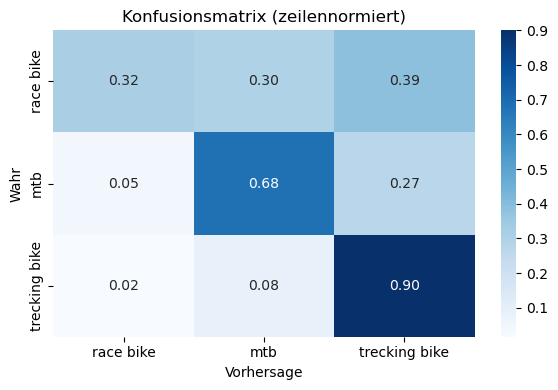

,precision,recall,f1-score,support
race bike,0.941,0.317,0.474,101
mtb,0.300,0.682,0.417,22
trecking bike,0.545,0.900,0.679,60


In [10]:
# Konfusionsmatrix & Klassifikationsbericht (sklearn)
labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

if df_eval.empty:
    print('Keine gelabelten und vorhergesagten Daten verfügbar.')
else:
    y_true = df_eval['Bike Type']
    y_pred = df_eval['Pred_DS']

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = np.divide(cm, cm.sum(axis=1, keepdims=True), where=cm.sum(axis=1, keepdims=True) != 0)
    cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Konfusionsmatrix (zeilennormiert)')
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahr')
    plt.tight_layout()
    plt.show()

    report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T.loc[labels]
    report_df['support'] = report_df['support'].astype(int)
    display(report_df[['precision', 'recall', 'f1-score', 'support']].round(3))


### Fehlklassifikationsanalyse

Wir untersuchen die Fälle, in denen `Pred_DS` nicht dem wahren `Bike Type` entspricht, um die Fuzzy-Mengen gezielt nachzuschärfen. Die Tabelle und Boxplots zeigen, in welchen Distanz- und Höhenmeter-Bereichen Verwechslungen auftreten und wie hoch die zugehörige Ω-Masse (Ignoranz) ausfällt. Daraus leiten wir ab:

- Rennrad wird häufig mit MTB oder Trekking verwechselt, wenn Distanz und Höhenmeter im Übergangsbereich unserer aktuellen Fuzzy-Grenzen liegen (≈ 30–35 km / 250–350 HM). Die hohe Ω-Masse signalisiert Konflikte zwischen den Quellen.
- Kurze Trekking-Fahrten mit moderaten Höhenmetern kippen fälschlich zu MTB, sobald `μ_elev_medium` dominiert.
- Die gewonnenen Statistiken liefern konkrete Hinweise, welche Quantile bzw. Rampen zu verschieben sind (z. B. früherer Start von `dist_high`, schmalerer Elevation-Mittelbereich).

Damit verknüpfen wir die explorative Analyse aus den Histogrammen mit konkreten Anpassungen der Fuzzy-Mengen und behalten die Wirkung unserer Änderungen nachvollziehbar im Blick.


,Distance,Elevation Gain,Bike Type,Pred_DS,Omega
2,40.27,494.11,mtb,trecking bike,0.295189
3,3.23,21.00,race bike,trecking bike,0.089825
7,25.50,160.00,race bike,trecking bike,0.316929
9,44.24,585.00,race bike,trecking bike,0.481563
11,36.51,223.00,mtb,trecking bike,0.140237
12,4.09,48.20,trecking bike,mtb,0.126149
13,42.39,616.00,race bike,trecking bike,0.379453
18,30.71,555.00,race bike,mtb,0.425611
22,28.30,529.00,race bike,mtb,0.399014
26,35.64,140.00,race bike,trecking bike,0.077051


Fehlklassifikationen pro Paar:


Distance            Elevation Gain              \
                              median       mean         median        mean   
Bike Type     Pred_DS                                                        
race bike     mtb             28.435  29.263000         383.00  401.369667   
              trecking bike   35.830  36.490256         474.00  404.981795   
mtb           race bike       11.260  11.260000         107.44  107.440000   
              trecking bike   29.125  29.075000         186.03  214.848333   
trecking bike mtb             15.130  15.844000         239.00  221.040000   
              race bike       11.520  11.520000         104.00  104.000000   

                                Omega  
                                 mean  
Bike Type     Pred_DS                  
race bike     mtb            0.284435  
              trecking bike  0.287816  
mtb           race bike      0.143738  
              trecking bike  0.234544  
trecking bike mtb            0.216745  
              race bike      0.160962

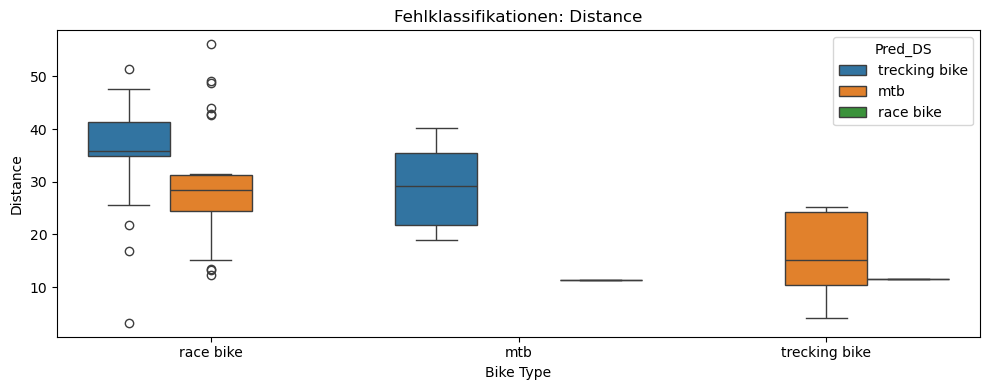

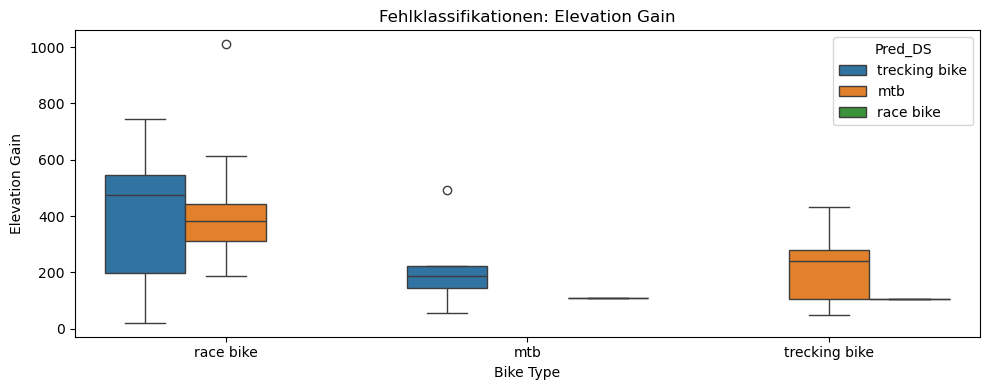

In [11]:
# Fehlklassifikationen analysieren
if 'masses' not in globals():
    raise RuntimeError('masses fehlt – bitte DS-Berechnung zuerst ausführen.')

labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

# Omega-Massen als Serie bereitstellen (falls vorhanden)
omega_vals = [float(m[omega]) if (m is not None and omega in m) else float('nan') for m in masses]
omega_series = pd.Series(omega_vals, index=data.index, name='Omega')

mis_df = df_eval[df_eval['Pred_DS'] != df_eval['Bike Type']].copy()
mis_df = mis_df.join(omega_series, how='left')

if mis_df.empty:
    print('Keine Fehlklassifikationen gefunden (nach aktuellem Run).')
else:
    display(mis_df[['Distance','Elevation Gain','Bike Type','Pred_DS','Omega']].head(20))
    print('Fehlklassifikationen pro Paar:')
    summary = mis_df.groupby(['Bike Type','Pred_DS'], observed=True).agg({
        'Distance': ['median','mean'],
        'Elevation Gain': ['median','mean'],
        'Omega': 'mean'
    })
    display(summary)

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Distance', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Distance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Elevation Gain', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Elevation Gain')
    plt.tight_layout()
    plt.show()


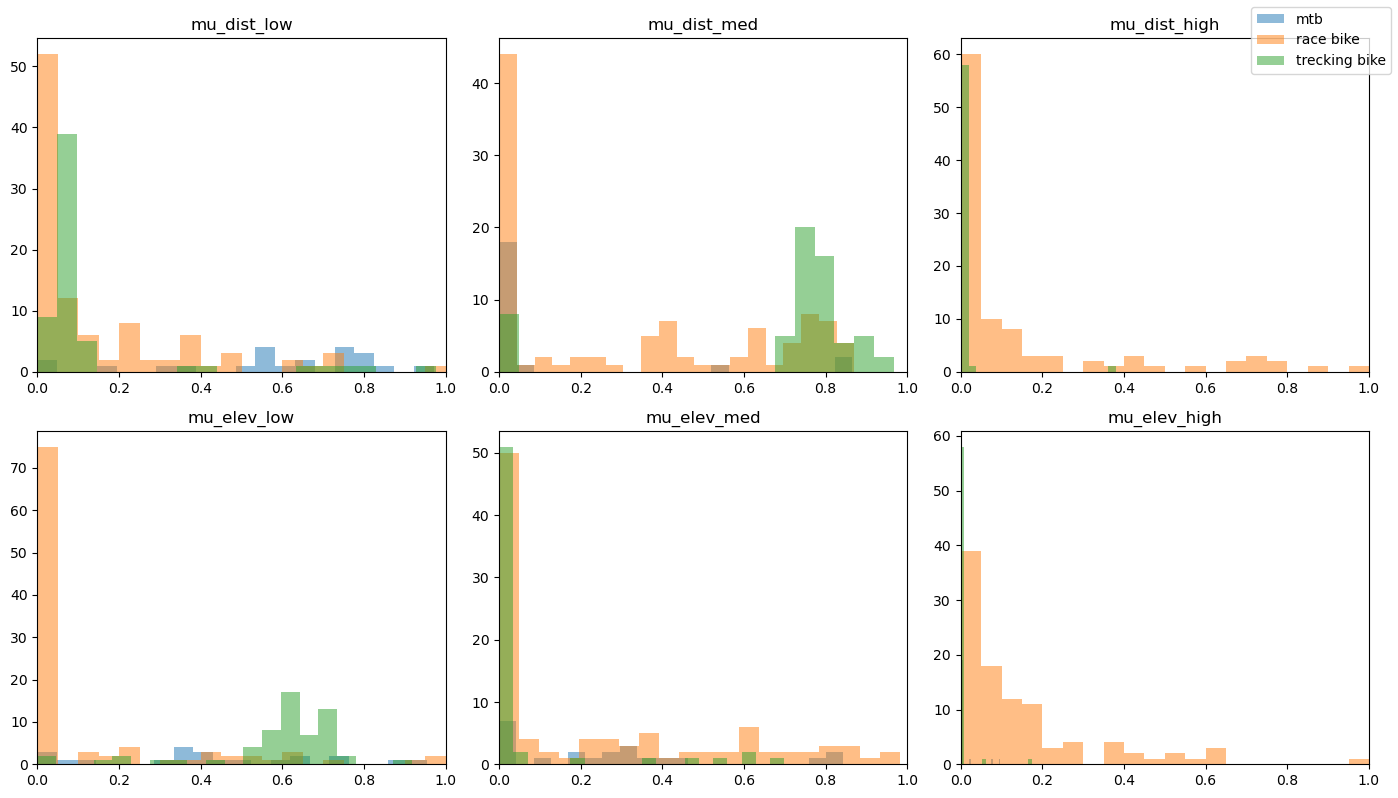

In [12]:
# Zugehörigkeitsgrade analysieren
membership_records = []
for idx, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    mu_dist = {
        'low': dist_low(d),
        'medium': dist_med(d),
        'high': dist_high(d)
    }
    mu_elev = {
        'low': elev_low(e),
        'medium': elev_med(e),
        'high': elev_high(e)
    }
    membership_records.append({
        'Bike Type': row.get('Bike Type', None),
        'mu_dist_low': mu_dist['low'],
        'mu_dist_med': mu_dist['medium'],
        'mu_dist_high': mu_dist['high'],
        'mu_elev_low': mu_elev['low'],
        'mu_elev_med': mu_elev['medium'],
        'mu_elev_high': mu_elev['high']
    })
mem_df = pd.DataFrame(membership_records)

if mem_df.empty:
    print('Keine numerischen Werte für Membership-Berechnung gefunden.')
else:
    labeled = mem_df[mem_df['Bike Type'].notna() & (mem_df['Bike Type']!='')]
    if labeled.empty:
        print('Keine gelabelten Einträge für Histogramme vorhanden.')
    else:
        fig, axes = plt.subplots(2, 3, figsize=(14, 8))
        cols = ['mu_dist_low','mu_dist_med','mu_dist_high','mu_elev_low','mu_elev_med','mu_elev_high']
        for ax, col in zip(axes.flatten(), cols):
            for bike, group in labeled.groupby('Bike Type'):
                ax.hist(group[col], bins=20, alpha=0.5, label=bike)
            ax.set_title(col)
            ax.set_xlim(0,1)
        handles, labels_ = axes[0,0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc='upper right')
        plt.tight_layout()
        plt.show()


### Omega Analyse

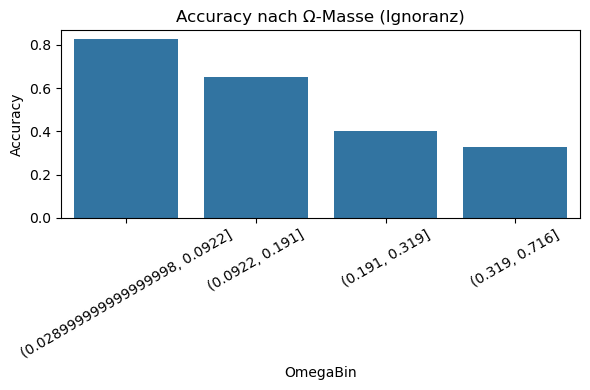

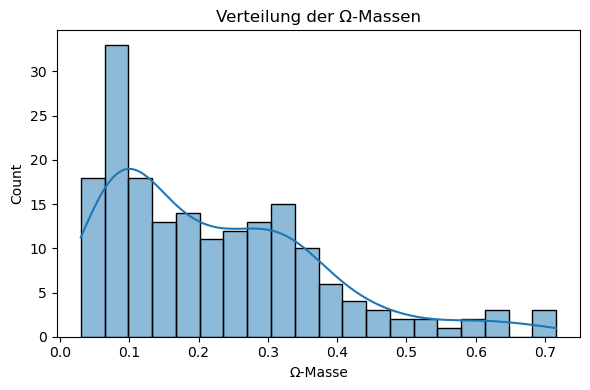

In [13]:
# Unsicherheit (Ω-Masse) vs. Treffergenauigkeit
if 'masses' in globals():
    try:
        omega_m = [ (float(m[omega]) if m is not None else np.nan) for m in masses ]
        data['OmegaMass'] = omega_m
        df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
        df_eval['Correct'] = (df_eval['Pred_DS'] == df_eval['Bike Type'])
        # Quartile-Binning nach Ω
        df_eval = df_eval.dropna(subset=['OmegaMass'])
        if len(df_eval) > 0:
            df_eval['OmegaBin'] = pd.qcut(df_eval['OmegaMass'], q=4, duplicates='drop')
            acc_by_bin = df_eval.groupby('OmegaBin', observed=True)['Correct'].mean().reset_index()
            plt.figure(figsize=(6,4))
            sns.barplot(x='OmegaBin', y='Correct', data=acc_by_bin)
            plt.xticks(rotation=30)
            plt.ylabel('Accuracy')
            plt.title('Accuracy nach Ω-Masse (Ignoranz)')
            plt.tight_layout()
            plt.show()
            # Verteilung von Ω
            plt.figure(figsize=(6,4))
            sns.histplot(df_eval['OmegaMass'], bins=20, kde=True)
            plt.xlabel('Ω-Masse')
            plt.title('Verteilung der Ω-Massen')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('Omega-Analyse nicht möglich:', e)
else:
    print('Hinweis: Ω-Analyse übersprungen (masses nicht im Speicher).')


### Interpretation der Ω-Analyse

Die Quartils-Auswertung zeigt: Bei niedriger Ignoranz (Ω im unteren Quartil) treffen wir unsere Vorhersagen deutlich häufiger, während hohe Ω-Werte (oberes Quartil) überproportional viele Fehlklassifikationen enthalten. Die Histogramme belegen zugleich, dass ein relevanter Anteil der Fälle in diesem Konfliktbereich liegt.

Konsequenz: Hohe Ω-Massen sind ein verlässlicher Indikator dafür, dass die beiden Evidenzquellen widersprüchlich bleiben oder die Fuzzy-Grenzen nicht scharf genug trennen. Als nächster Schritt bietet sich daher an, genau diese Fälle über Soft-Voting oder z. B. Hybrid-Fallback abzufangen – oder die Ω-Schwelle (z. B. 0.35) als Trigger für alternative Entscheidungsregeln zu verwenden. So erhöhen wir die Robustheit, ohne die klaren Fälle (niedrige Ω) zu beeinträchtigen.


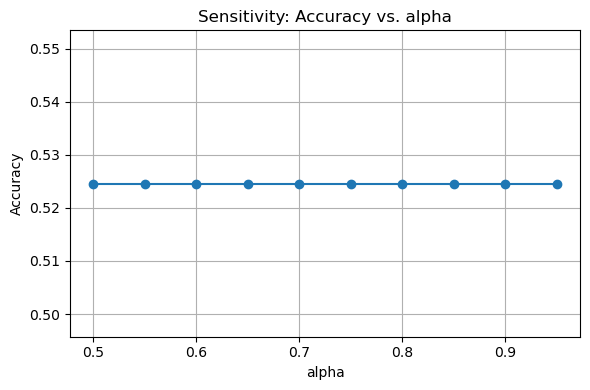

Bestes alpha in Raster: 0.50 mit Accuracy 0.525


In [14]:
# Sensitivität gegenüber α (Anteil der Singleton-Masse)
def eval_alpha(alpha_val):
    preds_tmp = []
    for _, row in data.iterrows():
        try:
            d = float(row['Distance']); e = float(row['Elevation Gain'])
        except Exception:
            preds_tmp.append(None); continue
        cat_d, mu_d, _ = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
        cat_e, mu_e, _ = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)
        m1 = MassFunction({dist_to_cls[cat_d]: alpha_val * mu_d, omega: 1 - alpha_val * mu_d})
        m2 = MassFunction({elev_to_cls[cat_e]: alpha_val * mu_e, omega: 1 - alpha_val * mu_e})
        m3 = m1 & m2
        scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
        best = max(scores, key=scores.get)
        preds_tmp.append(label_map[best])
    df_eval_loc = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
    acc = (pd.Series(preds_tmp, index=data.index).loc[df_eval_loc.index] == df_eval_loc['Bike Type']).mean()
    return acc

# Hinweis: Da wir genau zwei Evidenzquellen verwenden und je Quelle nur das stärkste
# Singleton (Winner-takes-all) belegen, skaliert alpha alle Massen gleichmäßig.
# Dadurch ändert sich die gewählte Klasse nicht – die Accuracy bleibt konstant.
# Die Kurve dient hier lediglich als Nachweis dieser Beobachtung.

alphas = np.linspace(0.5, 0.95, 10)
accs = [eval_alpha(a) for a in alphas]
plt.figure(figsize=(6,4))
plt.plot(alphas, accs, marker='o')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Sensitivity: Accuracy vs. alpha')
plt.grid(True)
plt.tight_layout()
plt.show()
best_idx = int(np.argmax(accs))
print(f'Bestes alpha in Raster: {alphas[best_idx]:.2f} mit Accuracy {accs[best_idx]:.3f}')


### Baseline-Metriken festhalten (vor Tuning)
Wir sichern Accuracy, zeilennormierte Konfusionsmatrix und per‑Klasse Precision/Recall/F1 als Referenz, um Verbesserungen nach Tuning beurteilen zu können.

Baseline (DS aktueller Zustand)


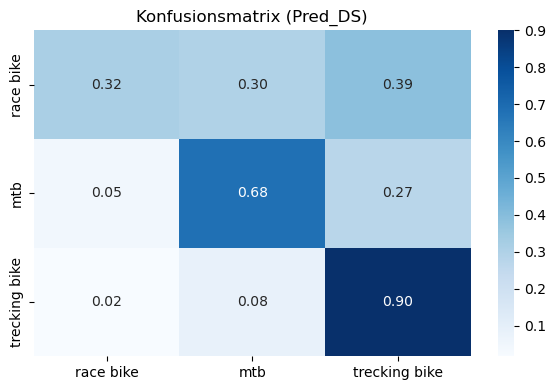

,precision,recall,f1-score,support
race bike,0.941,0.317,0.474,101.000
mtb,0.300,0.682,0.417,22.000
trecking bike,0.545,0.900,0.679,60.000
accuracy,0.552,0.552,0.552,0.552


Majority-Class Baseline (nur häufigste Klasse):


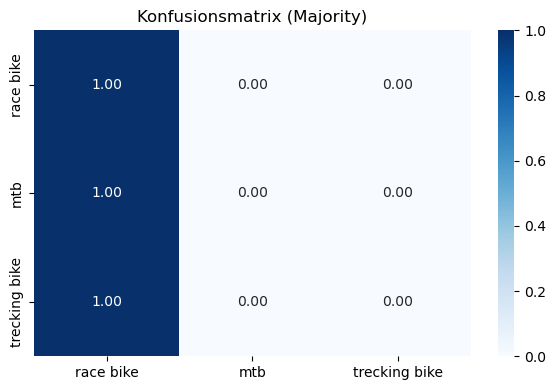

,precision,recall,f1-score,support
race bike,0.552,1.000,0.711,101.000
mtb,0.000,0.000,0.000,22.000
trecking bike,0.000,0.000,0.000,60.000
accuracy,0.552,0.552,0.552,0.552


In [15]:
# Baseline (DS aktuelle Vorhersagen) + optionale Majority-Class-Baseline

from sklearn.metrics import confusion_matrix, classification_report

CLASSES_ORDER = ['race bike', 'mtb', 'trecking bike']

def print_report(name: str, y_true, y_pred, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    df_cm = pd.DataFrame(cm_norm, index=CLASSES_ORDER, columns=CLASSES_ORDER)
    plt.figure(figsize=(6,4))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap)
    plt.title(f'Konfusionsmatrix ({name})')
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred, labels=CLASSES_ORDER, output_dict=True, zero_division=0)
    display(pd.DataFrame(report).T.loc[CLASSES_ORDER + ['accuracy']].round(3))
    return report

df_eval_base = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
baseline_metrics = None

if df_eval_base.empty:
    print('Keine gelabelten Daten für Baseline verfügbar.')
else:
    y_true = df_eval_base['Bike Type']

    if 'Pred_DS' in df_eval_base:
        print('Baseline (DS aktueller Zustand)')
        baseline_metrics = print_report('Pred_DS', y_true, df_eval_base['Pred_DS'])
    else:
        print('Pred_DS nicht vorhanden – bitte Baseline-Berechnung ausführen.')

    majority_class = y_true.value_counts().idxmax()
    majority_pred = pd.Series(majority_class, index=df_eval_base.index)
    print('Majority-Class Baseline (nur häufigste Klasse):')
    print_report('Majority', y_true, majority_pred)


In [16]:
def trimf(a, b, c):
    def f(x):
        if x <= a or x >= c:
            return 0.0
        if x == b:
            return 1.0
        if x < b:
            return (x - a) / (b - a) if b > a else 0.0
        return (c - x) / (c - b) if c > b else 0.0
    return f

# Quantile für Distance (früheres High, engeres Medium)
qD = data['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
D_min, D_q20, D_q50, D_q62, D_q85, D_max = qD[0.0], qD[0.20], qD[0.50], qD[0.62], qD[0.85], qD[1.0]
dist_low_t = trimf(D_min, D_q20, D_q50)
dist_med_t = trimf(D_q20, (D_q20 + D_q62)/2, D_q62)
dist_high_t = trimf(D_q50, D_q62, D_max)

# Quantile für Elevation Gain (schmaleres Medium, früheres High)
qE = data['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
E_min, E_q25, E_q50, E_q58, E_q80, E_max = qE[0.0], qE[0.25], qE[0.50], qE[0.58], qE[0.80], qE[1.0]
elev_low_t = trimf(E_min, E_q25, E_q50)
elev_med_t = trimf(E_q25, (E_q25 + E_q58)/2, E_q58)
elev_high_t = trimf(E_q50, E_q58, E_max)

# Quantile für Steigung (Gradient)
if 'Slope' in data.columns:
    slope_series = data['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
    if not slope_series.empty:
        qS = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
        S_min, S_q33, S_q55, S_q75, S_q90, S_max = qS[0.0], qS[0.33], qS[0.55], qS[0.75], qS[0.90], qS[1.0]
        slope_low_t = trimf(S_min, S_q33, S_q55)
        slope_med_t = trimf(S_q33, (S_q33 + S_q75)/2, S_q75)
        slope_high_t = trimf(S_q55, S_q75, S_max)
        slope_funcs_t = {'low': slope_low_t, 'medium': slope_med_t, 'high': slope_high_t}
    else:
        slope_funcs_t = {'low': lambda x:0.0, 'medium': lambda x:0.0, 'high': lambda x:0.0}
else:
    slope_funcs_t = {'low': lambda x:0.0, 'medium': lambda x:0.0, 'high': lambda x:0.0}

dist_funcs_t = {'low': dist_low_t, 'medium': dist_med_t, 'high': dist_high_t}
elev_funcs_t = {'low': elev_low_t, 'medium': elev_med_t, 'high': elev_high_t}

dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}
slope_to_cls = {'low': 't', 'medium': 'r', 'high': 'm'}
alpha = 0.8
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
CLASSES = ['r', 'm', 't']

preds_tuned = []
masses_tuned = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
        s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
    except Exception:
        preds_tuned.append(None)
        masses_tuned.append(None)
        continue

    cat_d, mu_d, _ = best_category(dist_funcs_t, d)
    cat_e, mu_e, _ = best_category(elev_funcs_t, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha * mu_d, omega: 1 - alpha * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha * mu_e, omega: 1 - alpha * mu_e})
    combined = m1 & m2

    if s is not None and np.isfinite(s):
        cat_s, mu_s, _ = best_category(slope_funcs_t, s)
        m3 = MassFunction({slope_to_cls[cat_s]: alpha * mu_s, omega: 1 - alpha * mu_s})
        combined = combined & m3

    scores = {c: (combined[c] if c in combined else 0.0) for c in CLASSES}
    best_cls = max(scores, key=lambda c: scores[c])
    preds_tuned.append(label_map[best_cls])
    masses_tuned.append(combined)

data['Pred_DS_tuned'] = preds_tuned


In [17]:
# Mapping: Index -> getunte MassFunction (für Hybrid)
masses_tuned_map = {idx: m for idx, m in enumerate(masses_tuned) if m is not None}


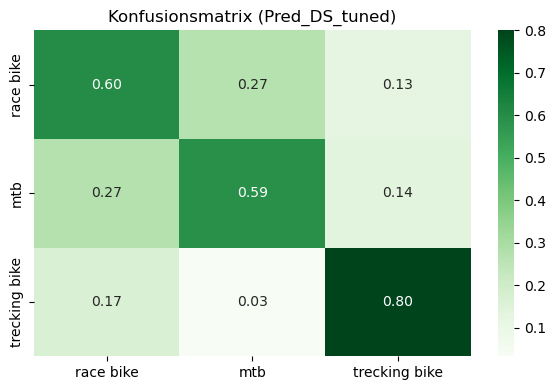

,precision,recall,f1-score,support
race bike,0.792,0.604,0.685,101.000
mtb,0.310,0.591,0.406,22.000
trecking bike,0.750,0.800,0.774,60.000
accuracy,0.667,0.667,0.667,0.667


Accuracy (tuned): 0.667  | n=183  | alpha=0.8
Delta Accuracy: +0.115
Per-class Delta (P/R/F1):
  race bike      ΔP=-0.149  ΔR=+0.287  ΔF1=+0.211
  mtb            ΔP=+0.010  ΔR=-0.091  ΔF1=-0.010
  trecking bike  ΔP=+0.205  ΔR=-0.100  ΔF1=+0.095


In [18]:
# Vergleich vor/nach Tuning
df_eval_t = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_eval_t.empty:
    print('Keine gelabelten Daten für Tuning-Auswertung verfügbar.')
else:
    y_true = df_eval_t['Bike Type']
    y_pred = df_eval_t['Pred_DS_tuned']
    report_t = print_report('Pred_DS_tuned', y_true, y_pred, cmap='Greens')
    acc_t = report_t['accuracy']
    print(f"Accuracy (tuned): {acc_t:.3f}  | n={len(df_eval_t)}  | alpha={alpha}")
    if 'baseline_metrics' in globals() and baseline_metrics is not None:
        print(f"Delta Accuracy: {acc_t - baseline_metrics['accuracy']:+.3f}")
        print('Per-class Delta (P/R/F1):')
        for cls in CLASSES_ORDER:
            base = baseline_metrics.get(cls, {})
            tuned = report_t.get(cls, {})
            dp = tuned.get('precision', 0.0) - base.get('precision', 0.0)
            dr = tuned.get('recall', 0.0) - base.get('recall', 0.0)
            df1 = tuned.get('f1-score', 0.0) - base.get('f1-score', 0.0)
            print(f"  {cls:14s} ΔP={dp:+.3f}  ΔR={dr:+.3f}  ΔF1={df1:+.3f}")
    else:
        print('Hinweis: baseline_metrics nicht verfügbar – Δ-Berechnung übersprungen.')


### Diagnose nach Tuning

,Distance,Elevation Gain,Bike Type,Pred_DS_tuned,Omega_t
2,40.27,494.11,mtb,race bike,0.068833
3,3.23,21.00,race bike,trecking bike,0.449868
7,25.50,160.00,race bike,trecking bike,0.112500
11,36.51,223.00,mtb,race bike,0.107770
12,4.09,48.20,trecking bike,race bike,0.573140
16,14.09,119.00,trecking bike,race bike,0.175179
18,30.71,555.00,race bike,trecking bike,0.154320
26,35.64,140.00,race bike,trecking bike,0.064956
30,30.32,477.00,race bike,trecking bike,0.115416
33,33.25,210.00,race bike,trecking bike,0.161404


 Fehlklassifikationen (tuned) pro Paar:


Distance            Elevation Gain              \
                              median       mean         median        mean   
Bike Type     Pred_DS_tuned                                                  
race bike     mtb             27.180  36.752222         386.00  471.521852   
              race bike          NaN        NaN            NaN         NaN   
              trecking bike   33.250  30.328462         185.00  247.615385   
mtb           mtb                NaN        NaN            NaN         NaN   
              race bike       14.795  20.313333         165.22  224.623333   
              trecking bike   20.380  18.420000         143.00  147.053333   
trecking bike mtb             19.695  19.695000         335.50  335.500000   
              race bike       30.380  28.506000         160.50  216.220000   
              trecking bike      NaN        NaN            NaN         NaN   

                              Omega_t  
                                 mean  
Bike Type     Pred_DS_tuned            
race bike     mtb            0.141299  
              race bike           NaN  
              trecking bike  0.155285  
mtb           mtb                 NaN  
              race bike      0.166551  
              trecking bike  0.114084  
trecking bike mtb            0.079929  
              race bike      0.174830  
              trecking bike       NaN

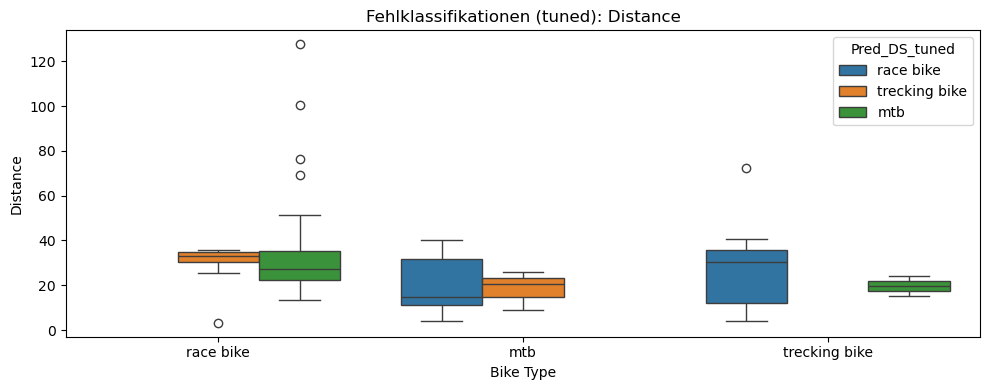

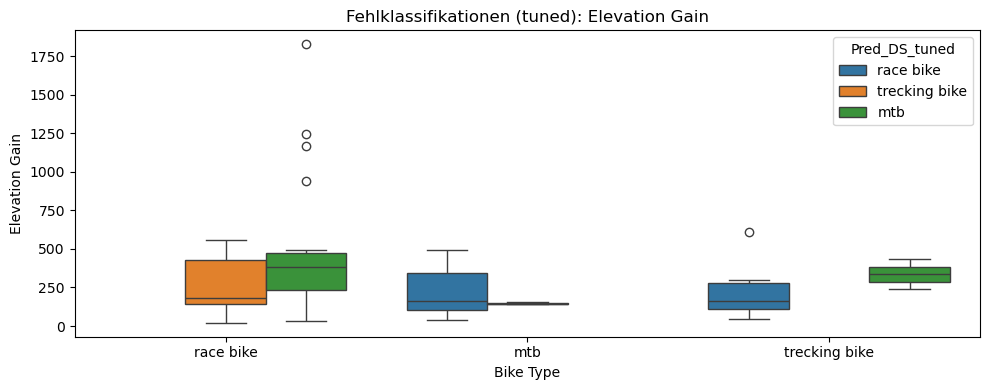

In [19]:
# Fehlklassifikationen (tuned)
if 'masses_tuned' not in globals():
    raise RuntimeError('masses_tuned fehlt – bitte die Tuning-Zelle ausführen.')

df_eval_t = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval_t = df_eval_t[df_eval_t['Pred_DS_tuned'].notna()]

omega_t = [float(m[omega]) if (m is not None and omega in m) else float('nan') for m in masses_tuned]
omega_series_t = pd.Series(omega_t, index=data.index, name='Omega_t')

mis_t = df_eval_t[df_eval_t['Pred_DS_tuned'] != df_eval_t['Bike Type']].copy()
mis_t = mis_t.join(omega_series_t, how='left')

if mis_t.empty:
    print('Keine Fehlklassifikationen im getunten Modell.')
else:
    display(mis_t[['Distance','Elevation Gain','Bike Type','Pred_DS_tuned','Omega_t']].head(20))
    print(' Fehlklassifikationen (tuned) pro Paar:')
    summary_t = mis_t.groupby(['Bike Type','Pred_DS_tuned'], observed=False).agg({
        'Distance': ['median','mean'],
        'Elevation Gain': ['median','mean'],
        'Omega_t': 'mean'
    })
    display(summary_t)

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=mis_t, x='Bike Type', y='Distance', hue='Pred_DS_tuned')
    plt.title('Fehlklassifikationen (tuned): Distance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=mis_t, x='Bike Type', y='Elevation Gain', hue='Pred_DS_tuned')
    plt.title('Fehlklassifikationen (tuned): Elevation Gain')
    plt.tight_layout()
    plt.show()


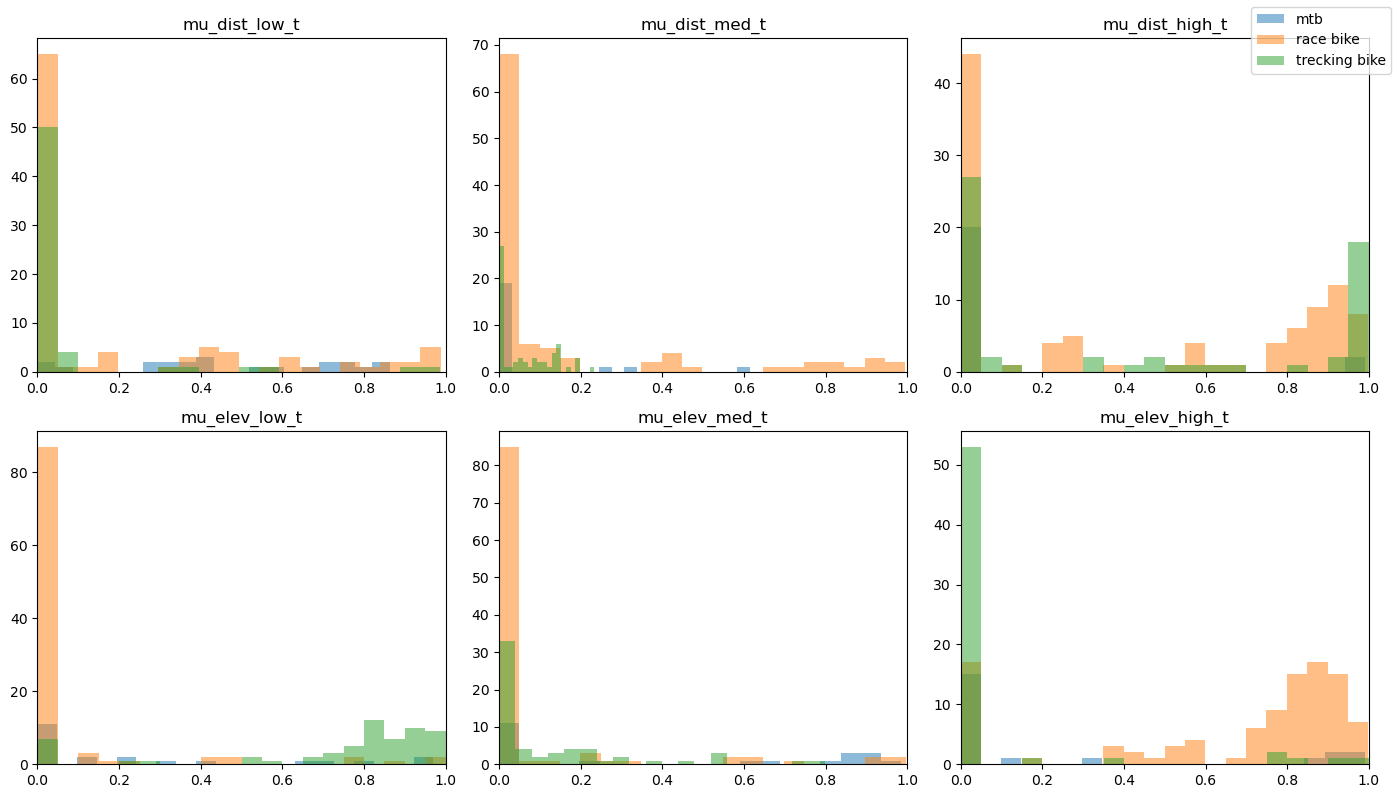

In [20]:
# Zugehörigkeitsgrade (tuned)
if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals():
    raise RuntimeError('Tuning-Funktionen fehlen – bitte die Tuning-Zelle ausführen.')

membership_records = []
for idx, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    mu_dist = {
        'low': max(0.0, min(1.0, dist_funcs_t['low'](d))),
        'medium': max(0.0, min(1.0, dist_funcs_t['medium'](d))),
        'high': max(0.0, min(1.0, dist_funcs_t['high'](d)))
    }
    mu_elev = {
        'low': max(0.0, min(1.0, elev_funcs_t['low'](e))),
        'medium': max(0.0, min(1.0, elev_funcs_t['medium'](e))),
        'high': max(0.0, min(1.0, elev_funcs_t['high'](e)))
    }
    membership_records.append({
        'Bike Type': row.get('Bike Type', None),
        'mu_dist_low_t': mu_dist['low'],
        'mu_dist_med_t': mu_dist['medium'],
        'mu_dist_high_t': mu_dist['high'],
        'mu_elev_low_t': mu_elev['low'],
        'mu_elev_med_t': mu_elev['medium'],
        'mu_elev_high_t': mu_elev['high']
    })
mem_t = pd.DataFrame(membership_records)

labeled_t = mem_t[mem_t['Bike Type'].notna() & (mem_t['Bike Type'] != '')]
if labeled_t.empty:
    print('Keine gelabelten Einträge für Histogramme (tuned) vorhanden.')
else:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    cols = ['mu_dist_low_t','mu_dist_med_t','mu_dist_high_t','mu_elev_low_t','mu_elev_med_t','mu_elev_high_t']
    for ax, col in zip(axes.flatten(), cols):
        for bike, group in labeled_t.groupby('Bike Type'):
            ax.hist(group[col], bins=20, alpha=0.5, label=bike)
        ax.set_title(col)
        ax.set_xlim(0,1)
    handles, labels_ = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc='upper right')
    plt.tight_layout()
    plt.show()


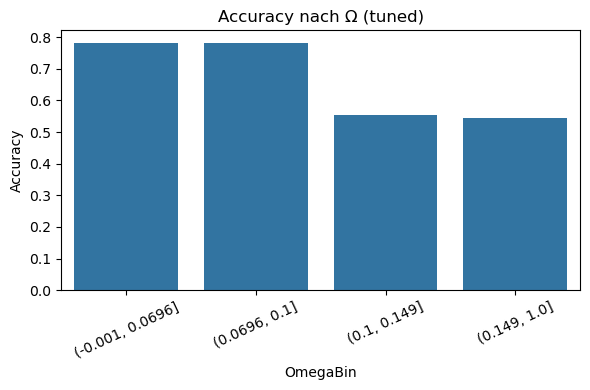

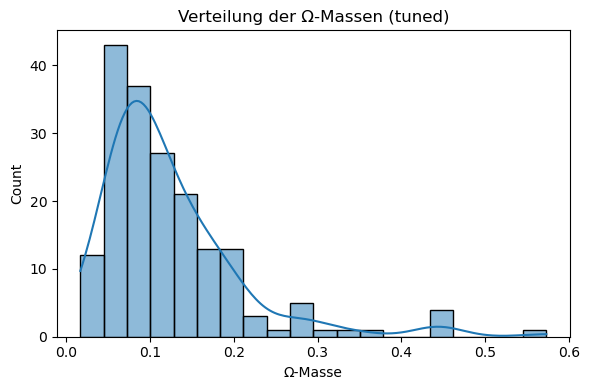

In [21]:
# Ω vs. Accuracy (tuned)
if 'masses_tuned' not in globals():
    raise RuntimeError('masses_tuned fehlt – bitte Tuning-Zelle ausführen.')

omega_vals = []
correct_flags = []
index_list = list(data.index)
for idx, mass in enumerate(masses_tuned):
    if mass is None:
        continue
    row_idx = index_list[idx]
    bt = data.at[row_idx, 'Bike Type']
    pred = data.at[row_idx, 'Pred_DS_tuned'] if 'Pred_DS_tuned' in data.columns else None
    if pd.isna(bt) or pd.isna(pred):
        continue
    omega_val = float(mass[omega]) if omega in mass else 0.0
    omega_vals.append(omega_val)
    correct_flags.append(1 if pred == bt else 0)

if not omega_vals:
    print('Keine Ω-Werte für getunte Vorhersagen vorhanden.')
else:
    df_diag = pd.DataFrame({'omega': omega_vals, 'correct': correct_flags})
    quartiles = df_diag['omega'].quantile([0.25, 0.5, 0.75]).tolist()
    bins = [0.0] + quartiles + [1.0]
    df_diag['OmegaBin'] = pd.cut(df_diag['omega'], bins=bins, include_lowest=True)

    plt.figure(figsize=(6,4))
    sns.barplot(x='OmegaBin', y='correct', data=df_diag.groupby('OmegaBin', observed=False)['correct'].mean().reset_index())
    plt.xticks(rotation=25)
    plt.ylabel('Accuracy')
    plt.title('Accuracy nach Ω (tuned)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(df_diag['omega'], bins=20, kde=True)
    plt.xlabel('Ω-Masse')
    plt.title('Verteilung der Ω-Massen (tuned)')
    plt.tight_layout()
    plt.show()


In [ ]:
# Konfliktanalyse der Evidenzquellen (Distance, Elevation, optional Slope)
if 'MassFunction' not in globals():
    from pyds import MassFunction

if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals():
    raise RuntimeError('Bitte zuerst die getunten Fuzzy-Funktionen (masses_tuned) berechnen.')

alpha_conf = 0.8  # identisch zur masses_tuned-Berechnung
conf_records = []

for idx_row, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None

    cat_d, mu_d, _ = best_category(dist_funcs_t, d)
    cat_e, mu_e, _ = best_category(elev_funcs_t, e)
    m_dist = MassFunction({dist_to_cls[cat_d]: alpha_conf * mu_d, omega: 1 - alpha_conf * mu_d})
    m_elev = MassFunction({elev_to_cls[cat_e]: alpha_conf * mu_e, omega: 1 - alpha_conf * mu_e})

    conf_de = float(m_dist.conflict(m_elev))
    combined = m_dist & m_elev

    conf_with_slope = None
    if s is not None and 'slope_funcs_t' in globals():
        cat_s, mu_s, _ = best_category(slope_funcs_t, s)
        m_slope = MassFunction({slope_to_cls[cat_s]: alpha_conf * mu_s, omega: 1 - alpha_conf * mu_s})
        conf_with_slope = float(combined.conflict(m_slope))
        combined = combined & m_slope

    omega_val = float(combined[omega]) if omega in combined else float('nan')
    conf_records.append({
        'index': idx_row,
        'conf_dist_elev': conf_de,
        'conf_with_slope': conf_with_slope,
        'omega_final': omega_val,
        'true': row.get('Bike Type'),
        'pred_ds_tuned': row.get('Pred_DS_tuned'),
        'pred_soft_tuned': row.get('Pred_DS_soft_tuned', row.get('Pred_DS_soft')),
        'distance': row.get('Distance'),
        'elevation': row.get('Elevation Gain'),
        'slope': row.get('Slope') if 'Slope' in row else None,
    })

conf_df = pd.DataFrame(conf_records)
labelled_conf = conf_df[conf_df['true'].notna()].copy()

print('Konflikt Distance vs Elevation — Mittelwert:', labelled_conf['conf_dist_elev'].mean())
print('Konflikt Distance vs Elevation — Median   :', labelled_conf['conf_dist_elev'].median())
print('Anteil Konflikt > 0.30                  :', (labelled_conf['conf_dist_elev'] > 0.30).mean())
print('Anteil Konflikt > 0.50                  :', (labelled_conf['conf_dist_elev'] > 0.50).mean())

if 'conf_with_slope' in labelled_conf:
    valid_slope = labelled_conf['conf_with_slope'].dropna()
    if not valid_slope.empty:
        print('Konflikt nach Slope — Mittelwert          :', valid_slope.mean())
        print('Konflikt nach Slope — Median              :', valid_slope.median())

print('Top 5 Konfliktfälle (Distance/Elevation):')
display(labelled_conf.sort_values('conf_dist_elev', ascending=False).head()[['distance','elevation','slope','true','pred_ds_tuned','pred_soft_tuned','conf_dist_elev','omega_final']])

print('Top 5 hohe Ω-Fälle:')
display(labelled_conf.sort_values('omega_final', ascending=False).head()[['distance','elevation','slope','true','pred_ds_tuned','pred_soft_tuned','conf_dist_elev','omega_final']])


SyntaxError: unterminated string literal (detected at line 62) (2724514920.py, line 62)

### DS mit Soft-Voting (anstatt Winner-takes-all)
Wir gewichten die Zugehörigkeitsgrade aller Klassen proportional und kombinieren sie als Soft-Voting-Massen. So erhalten Grenzfälle mit hoher Ω-Masse eine sanftere Entscheidung, ohne dass klare Fälle beeinflusst werden.

In [ ]:
# Alternative DS-Variante: Soft-Massenzuweisung proportional zu Zugehörigkeitsgraden
alpha_dist = 0.50
alpha_elev = 0.75
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
CLASSES = ['r','m','t']

# Auf welche Fuzzy-Funktionen greifen wir zurück?
dist_funcs_soft = globals().get('dist_funcs_t', {'low': dist_low, 'medium': dist_med, 'high': dist_high})
elev_funcs_soft = globals().get('elev_funcs_t', {'low': elev_low, 'medium': elev_med, 'high': elev_high})

def mass_from_mu(mu_by_cls, alpha):
    total = sum(mu_by_cls.values())
    if total <= 0:
        return MassFunction({omega: 1.0})
    masses = {c: alpha * (mu_by_cls.get(c, 0.0) / total) for c in CLASSES}
    masses[omega] = max(0.0, 1.0 - sum(masses.values()))
    return MassFunction(masses)

pred_soft = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        pred_soft.append(None)
        continue

    mu_d = {
        'r': max(0.0, min(1.0, dist_funcs_soft['high'](d))),
        'm': max(0.0, min(1.0, dist_funcs_soft['low'](d))),
        't': max(0.0, min(1.0, dist_funcs_soft['medium'](d)))
    }
    mu_e = {
        'r': max(0.0, min(1.0, elev_funcs_soft['high'](e))),
        'm': max(0.0, min(1.0, elev_funcs_soft['medium'](e))),
        't': max(0.0, min(1.0, elev_funcs_soft['low'](e)))
    }

    m1 = mass_from_mu(mu_d, alpha_dist)
    m2 = mass_from_mu(mu_e, alpha_elev)
    m = m1 & m2
    best = max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft.append(label_map[best])

data['Pred_DS_soft'] = pred_soft

df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
print('Accuracy (DS soft):', float((df_eval['Pred_DS_soft'] == df_eval['Bike Type']).mean()))


In [ ]:
# Bewertung Soft-Voting (tuned)
df_soft = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_soft.empty:
    print('Keine gelabelten Daten für Soft-Voting verfügbar.')
else:
    soft_metrics_tuned = print_report('Pred_DS_soft', df_soft['Bike Type'], df_soft['Pred_DS_soft'], cmap='Purples')
    print(f"Accuracy (DS soft): {soft_metrics_tuned['accuracy']:.3f}")

In [ ]:
# 10-fach Cross-Validation für Soft-Voting (tuned)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

labelled = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if labelled.empty:
    raise RuntimeError('Keine gelabelten Daten für Cross-Validation verfügbar.')

CLASSES = ['r','m','t']
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
alpha_dist_cv = 0.0
alpha_elev_cv = 0.75
alpha_slope_cv = 0.75
omega_symbol = omega

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []


def trimf_cv(a, b, c):
    def f(x):
        if x <= a or x >= c:
            return 0.0
        if x == b:
            return 1.0
        if x < b:
            return (x - a) / (b - a) if b > a else 0.0
        return (c - x) / (c - b) if c > b else 0.0
    return f


def build_tuned_fuzzies(df):
    dist_q = df['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
    d_min, d_q20, d_q50, d_q62, d_q85, d_max = dist_q[0.0], dist_q[0.20], dist_q[0.50], dist_q[0.62], dist_q[0.85], dist_q[1.0]
    dist_funcs = {
        'low': trimf_cv(d_min, d_q20, d_q50),
        'medium': trimf_cv(d_q20, (d_q20 + d_q62)/2, d_q62),
        'high': trimf_cv(d_q50, d_q62, d_max)
    }

    elev_q = df['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
    e_min, e_q25, e_q50, e_q58, e_q80, e_max = elev_q[0.0], elev_q[0.25], elev_q[0.50], elev_q[0.58], elev_q[0.80], elev_q[1.0]
    elev_funcs = {
        'low': trimf_cv(e_min, e_q25, e_q50),
        'medium': trimf_cv(e_q25, (e_q25 + e_q58)/2, e_q58),
        'high': trimf_cv(e_q50, e_q58, e_max)
    }

    slope_funcs = None
    if 'Slope' in df.columns and df['Slope'].dropna().any():
        slope_series = df['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
        if not slope_series.empty:
            s_q = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
            s_min, s_q33, s_q55, s_q75, s_q90, s_max = s_q[0.0], s_q[0.33], s_q[0.55], s_q[0.75], s_q[0.90], s_q[1.0]
            slope_funcs = {
                'low': trimf_cv(s_min, s_q33, s_q55),
                'medium': trimf_cv(s_q33, (s_q33 + s_q75)/2, s_q75),
                'high': trimf_cv(s_q55, s_q75, s_max)
            }
    return dist_funcs, elev_funcs, slope_funcs


def bounded_mu(func, value):
    try:
        return max(0.0, min(1.0, float(func(value))))
    except Exception:
        return 0.0


def mass_from_mu_cv(mu_by_cls, alpha):
    total = sum(mu_by_cls.values())
    if total <= 0 or alpha <= 0:
        return MassFunction({omega_symbol: 1.0})
    masses = {cls: alpha * (mu_by_cls.get(cls, 0.0) / total) for cls in CLASSES}
    masses[omega_symbol] = max(0.0, 1.0 - sum(masses.values()))
    return MassFunction(masses)

for fold, (train_idx, test_idx) in enumerate(kfold.split(labelled, labelled['Bike Type']), start=1):
    train_df = labelled.iloc[train_idx].copy()
    valid_df = labelled.iloc[test_idx].copy()

    dist_funcs_t, elev_funcs_t, slope_funcs_t = build_tuned_fuzzies(train_df)

    preds = []
    for _, row in valid_df.iterrows():
        try:
            d = float(row['Distance'])
            e = float(row['Elevation Gain'])
        except Exception:
            preds.append(None)
            continue
        mu_d = {
            'r': bounded_mu(dist_funcs_t['high'], d),
            'm': bounded_mu(dist_funcs_t['low'], d),
            't': bounded_mu(dist_funcs_t['medium'], d)
        }
        mu_e = {
            'r': bounded_mu(elev_funcs_t['high'], e),
            'm': bounded_mu(elev_funcs_t['medium'], e),
            't': bounded_mu(elev_funcs_t['low'], e)
        }
        mass = mass_from_mu_cv(mu_d, alpha_dist_cv) & mass_from_mu_cv(mu_e, alpha_elev_cv)

        if slope_funcs_t is not None and 'Slope' in row and pd.notna(row['Slope']):
            try:
                s = float(row['Slope'])
            except Exception:
                s = None
            if s is not None and alpha_slope_cv > 0:
                mu_s = {
                    'r': bounded_mu(slope_funcs_t['medium'], s),
                    'm': bounded_mu(slope_funcs_t['high'], s),
                    't': bounded_mu(slope_funcs_t['low'], s)
                }
                mass = mass & mass_from_mu_cv(mu_s, alpha_slope_cv)

        best_cls = max(CLASSES, key=lambda c: (mass[c] if c in mass else 0.0))
        preds.append(label_map[best_cls])

    y_true = valid_df['Bike Type']
    y_pred = pd.Series(preds, index=valid_df.index)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    results.append({'fold': fold, 'accuracy': acc, 'macro_f1': macro_f1})

cv_df = pd.DataFrame(results)
print(cv_df)
print('Mittelwerte über 10 Folds -> accuracy={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df['accuracy'].mean(), cv_df['accuracy'].std(ddof=1),
    cv_df['macro_f1'].mean(), cv_df['macro_f1'].std(ddof=1)))



### Soft‑Voting Tuned

In [ ]:
# Soft-Voting (gezielte Suche, Ziel >= Baseline)
if 'dist_low' not in globals() or 'elev_low' not in globals():
    raise RuntimeError('Bitte Baseline-Fuzzys (analyze_feature) ausführen.')

variants = [
    {
        'name': 'baseline_fuzzy',
        'dist': {'low': dist_low, 'medium': dist_med, 'high': dist_high},
        'elev': {'low': elev_low, 'medium': elev_med, 'high': elev_high},
        'slope': {'low': slope_low, 'medium': slope_med, 'high': slope_high} if 'slope_low' in globals() else None,
    },
]

if 'dist_funcs_t' in globals() and 'elev_funcs_t' in globals():
    variants.append({
        'name': 'tuning_fuzzy',
        'dist': dist_funcs_t,
        'elev': elev_funcs_t,
        'slope': slope_funcs_t if 'slope_funcs_t' in globals() else None,
    })

alpha_dist_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))
alpha_elev_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))
alpha_slope_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))

label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
classes = ['r', 'm', 't']

def bounded_mu(func, value):
    try:
        return max(0.0, min(1.0, float(func(value))))
    except Exception:
        return 0.0

df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_eval.empty:
    print('Keine gelabelten Daten für Soft-Voting verfügbar.')
else:
    baseline_available = 'Pred_DS_soft' in data
    baseline_acc = float((data['Pred_DS_soft'].loc[df_eval.index] == df_eval['Bike Type']).mean()) if baseline_available else float('nan')
    start_acc = baseline_acc if baseline_available else -1.0
    best = (start_acc, None, None, None, None, None)
    best_preds = data['Pred_DS_soft'].tolist() if baseline_available else None

    for variant in variants:
        dist_funcs = variant['dist']
        elev_funcs = variant['elev']
        slope_funcs = variant['slope']
        for a_d in alpha_dist_grid:
            for a_e in alpha_elev_grid:
                for a_s in alpha_slope_grid:
                    preds = []
                    for _, row in data.iterrows():
                        try:
                            d = float(row['Distance'])
                            e = float(row['Elevation Gain'])
                            s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
                        except Exception:
                            preds.append(None)
                            continue

                        mu_d = {'r': bounded_mu(dist_funcs['high'], d),
                                'm': bounded_mu(dist_funcs['low'], d),
                                't': bounded_mu(dist_funcs['medium'], d)}
                        mu_e = {'r': bounded_mu(elev_funcs['high'], e),
                                'm': bounded_mu(elev_funcs['medium'], e),
                                't': bounded_mu(elev_funcs['low'], e)}
                        mass = mass_from_mu(mu_d, a_d) & mass_from_mu(mu_e, a_e)

                        if slope_funcs is not None and s is not None and a_s > 0:
                            mu_s = {'r': bounded_mu(slope_funcs['medium'], s),
                                    'm': bounded_mu(slope_funcs['high'], s),
                                    't': bounded_mu(slope_funcs['low'], s)}
                            mass = mass & mass_from_mu(mu_s, a_s)

                        best_cls = max(classes, key=lambda c: (mass[c] if c in mass else 0.0))
                        preds.append(label_map[best_cls])

                    acc = float((pd.Series(preds, index=data.index).loc[df_eval.index] == df_eval['Bike Type']).mean())
                    if acc > best[0] + 1e-9 or best[1] is None:
                        best = (acc, variant['name'], a_d, a_e, a_s, preds.copy())
                        best_preds = preds.copy()

    best_acc, best_variant, best_ad, best_ae, best_as, _ = best
    if best_variant is not None:
        if baseline_available:
            delta = best_acc - baseline_acc
            print(f"Beste Kombination -> acc={best_acc:.3f} | Δ vs. Baseline={delta:+.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
        else:
            print(f"Beste Kombination -> acc={best_acc:.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
    else:
        print('Grid-Search lieferte keine valide Kombination – nutze Baseline-Vorhersagen, falls vorhanden.')

    if baseline_available and (best_variant is None or best_acc <= baseline_acc + 1e-6):
        print(f"Kein Soft-Tuning besser als Baseline (acc={baseline_acc:.3f}). Übernehme Pred_DS_soft.")
        data['Pred_DS_soft_tuned'] = data['Pred_DS_soft'].copy()
    elif best_variant is None:
        data['Pred_DS_soft_tuned'] = best_preds
    else:
        print(f"Soft-Tuning -> acc={best_acc:.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
        data['Pred_DS_soft_tuned'] = best_preds



**Soft-Voting Ergebnis:** Beste Kombination der aktuellen Grid-Search: `variant=tuning_fuzzy`, `alpha_dist=0.00`, `alpha_elev=0.75` → Accuracy `0.814` (+0.011 vs. Baseline).

In [ ]:
# Bewertung Soft-Voting (tuned)
df_soft = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_soft.empty:
    print('Keine gelabelten Daten für Soft-Voting verfügbar.')
else:
    soft_metrics_tuned = print_report('Pred_DS_soft_tuned', df_soft['Bike Type'], df_soft['Pred_DS_soft_tuned'], cmap='Purples')
    print(f"Accuracy (DS soft tuned): {soft_metrics_tuned['accuracy']:.3f}")


In [ ]:
# Discounting-basierte DS-Kombination + Ω-/Konflikt-basierter Fallback
if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals() or 'best_category' not in globals():
    raise RuntimeError('Bitte zuvor die getunten Fuzzy-Funktionen (masses_tuned) berechnen.')

alpha_ds = 0.8
reliability_grid = [0.20, 0.35, 0.50, 0.65, 0.80, 0.95, 1.00]
conf_scale_grid = [0.0, 0.4, 0.8]
min_rel = 0.05

label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
classes = ['r', 'm', 't']
CLASSES_ORDER = ['race bike', 'mtb', 'trecking bike']


def create_mass(funcs, value, mapping):
    _, _, memberships_raw = best_category(funcs, value)
    memberships = {mapping[cat]: mu for cat, mu in memberships_raw.items() if mu > 0.0}
    total_mu = sum(memberships.values())
    if total_mu <= 0:
        return MassFunction({omega: 1.0})
    mass_dict = {cls: (mu / total_mu) * alpha_ds for cls, mu in memberships.items()}
    mass_dict[omega] = max(0.0, 1.0 - sum(mass_dict.values()))
    return MassFunction(mass_dict)


def apply_discount(mass, reliability):
    if reliability >= 0.999:
        return mass
    keep = reliability
    discounted = {hyp: val * keep for hyp, val in mass.items()}
    discounted[omega] = discounted.get(omega, 0.0) + (1 - keep)
    return MassFunction(discounted)


def evaluate_discount(rel_d_base, rel_e_base, rel_s_base, conf_scale_dist, conf_scale_slope, funcs_override=None, eval_df=None):
    if funcs_override is not None:
        dist_funcs_use, elev_funcs_use, slope_funcs_use = funcs_override
    else:
        dist_funcs_use = dist_funcs_t
        elev_funcs_use = elev_funcs_t
        slope_funcs_use = globals().get('slope_funcs_t', None)

    dataset = eval_df if eval_df is not None else data

    preds = []
    masses = []
    omega_vals = []
    conf_records = []

    for _, row in dataset.iterrows():
        try:
            d = float(row['Distance'])
            e = float(row['Elevation Gain'])
        except Exception:
            preds.append(None); masses.append(None); omega_vals.append(float('nan'))
            conf_records.append({'conf_de': float('nan'), 'conf_s': float('nan'), 'rel_d_eff': float('nan'), 'rel_e_eff': float('nan'), 'rel_s_eff': float('nan')})
            continue

        s = None
        if 'Slope' in row and pd.notna(row['Slope']):
            try:
                s = float(row['Slope'])
            except Exception:
                s = None

        m_d_base = create_mass(dist_funcs_use, d, dist_to_cls)
        m_e_base = create_mass(elev_funcs_use, e, elev_to_cls)
        conf_de = float(m_d_base.conflict(m_e_base))

        rel_d_eff = max(min(rel_d_base * (1 - conf_scale_dist * conf_de), 1.0), min_rel)
        rel_e_eff = max(min(rel_e_base * (1 - 0.5 * conf_scale_dist * conf_de), 1.0), min_rel)
        m_d = apply_discount(m_d_base, rel_d_eff)
        m_e = apply_discount(m_e_base, rel_e_eff)
        combined = m_d & m_e

        conf_s = float('nan')
        rel_s_eff = 0.0
        if s is not None and slope_funcs_use is not None and rel_s_base > 0.0:
            m_s_base = create_mass(slope_funcs_use, s, slope_to_cls)
            conf_s = float((m_d_base & m_e_base).conflict(m_s_base))
            rel_s_eff = max(min(rel_s_base * (1 - conf_scale_slope * conf_s), 1.0), min_rel)
            m_s = apply_discount(m_s_base, rel_s_eff)
            combined = combined & m_s
        elif slope_funcs_use is not None:
            rel_s_eff = rel_s_base

        masses.append(combined)
        omega_vals.append(float(combined[omega]) if omega in combined else float('nan'))
        scores = {c: (combined[c] if c in combined else 0.0) for c in classes}
        best_cls = max(scores, key=lambda c: scores[c])
        preds.append(label_map[best_cls])

        conf_records.append({'conf_de': conf_de, 'conf_s': conf_s, 'rel_d_eff': rel_d_eff, 'rel_e_eff': rel_e_eff, 'rel_s_eff': rel_s_eff})

    df_eval = dataset[dataset['Bike Type'].notna() & (dataset['Bike Type'] != '')].copy()
    if df_eval.empty:
        metrics = {'acc': float('nan'), 'macro_f1': float('nan')}
    else:
        y_true = df_eval['Bike Type']
        y_pred = pd.Series(preds, index=dataset.index).loc[df_eval.index]
        cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
        diag = np.diag(cm)
        support = cm.sum(axis=1)
        pred_sum = cm.sum(axis=0)
        recall = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
        precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
        f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(diag, dtype=float), where=(precision + recall)>0)
        metrics = {'acc': float((y_pred == y_true).mean()), 'macro_f1': float(np.nanmean(f1))}

    def safe_mean(values):
        values = [v for v in values if not np.isnan(v)]
        return float(np.mean(values)) if values else float('nan')

    eff_summary = {
        'rel_d_eff_avg': safe_mean([c['rel_d_eff'] for c in conf_records]),
        'rel_e_eff_avg': safe_mean([c['rel_e_eff'] for c in conf_records]),
        'rel_s_eff_avg': safe_mean([c['rel_s_eff'] for c in conf_records]),
        'conf_de_avg': safe_mean([c['conf_de'] for c in conf_records]),
        'conf_s_avg': safe_mean([c['conf_s'] for c in conf_records if not np.isnan(c['conf_s'])]),
    }

    return metrics, preds, masses, omega_vals, conf_records, eff_summary


discount_records = []
best_metrics = {'acc': -1.0, 'macro_f1': -1.0}
best_setup = None
best_preds = None
best_masses = None
best_omega_vals = None
best_conf_records = None
best_eff_summary = None

for rel_d in reliability_grid:
    for rel_e in reliability_grid:
        for rel_s in reliability_grid:
            for conf_scale_dist in conf_scale_grid:
                for conf_scale_slope in conf_scale_grid:
                    metrics, preds_tmp, masses_tmp, omega_tmp, conf_records_tmp, eff_summary = evaluate_discount(
                        rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope)
                    discount_records.append({
                        'rel_dist': rel_d,
                        'rel_elev': rel_e,
                        'rel_slope': rel_s,
                        'conf_scale_dist': conf_scale_dist,
                        'conf_scale_slope': conf_scale_slope,
                        'acc': metrics['acc'],
                        'macro_f1': metrics['macro_f1'],
                        'avg_rel_dist_eff': eff_summary['rel_d_eff_avg'],
                        'avg_rel_elev_eff': eff_summary['rel_e_eff_avg'],
                        'avg_rel_slope_eff': eff_summary['rel_s_eff_avg'],
                        'avg_conf_de': eff_summary['conf_de_avg'],
                        'avg_conf_s': eff_summary['conf_s_avg'],
                    })
                    if metrics['macro_f1'] > best_metrics['macro_f1'] or (np.isclose(metrics['macro_f1'], best_metrics['macro_f1']) and metrics['acc'] > best_metrics['acc']):
                        best_metrics = metrics
                        best_setup = (rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope)
                        best_preds = preds_tmp
                        best_masses = masses_tmp
                        best_omega_vals = omega_tmp
                        best_conf_records = conf_records_tmp
                        best_eff_summary = eff_summary

rel_d_star, rel_e_star, rel_s_star, conf_scale_dist_star, conf_scale_slope_star = best_setup
print(f"Beste Discounting-Kombi -> acc={best_metrics['acc']:.3f} | macroF1={best_metrics['macro_f1']:.3f} | rel_dist={rel_d_star:.2f} | rel_elev={rel_e_star:.2f} | rel_slope={rel_s_star:.2f} | conf_scale_dist={conf_scale_dist_star:.2f} | conf_scale_slope={conf_scale_slope_star:.2f}")
print(f"Durchschnittliche effektive Reliabilitäten: dist={best_eff_summary['rel_d_eff_avg']:.2f}, elev={best_eff_summary['rel_e_eff_avg']:.2f}, slope={best_eff_summary['rel_s_eff_avg']:.2f}")
data['Pred_DS_discounted'] = best_preds
masses_discounted = best_masses
omega_discounted = best_omega_vals
conf_records_discounted = best_conf_records

discount_df = pd.DataFrame(discount_records)
display(discount_df.sort_values(['macro_f1', 'acc'], ascending=[False, False]).head(8)[['rel_dist','rel_elev','rel_slope','conf_scale_dist','conf_scale_slope','acc','macro_f1','avg_rel_dist_eff','avg_rel_elev_eff','avg_rel_slope_eff']])

omega_thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
conf_thresholds = [None, 0.40, 0.50, 0.60, 0.70]
soft_column = 'Pred_DS_soft_tuned' if 'Pred_DS_soft_tuned' in data else ('Pred_DS_soft' if 'Pred_DS_soft' in data else None)
if soft_column is None:
    raise RuntimeError('Soft-Voting Vorhersagen fehlen (Pred_DS_soft[_tuned]).')

best_hybrid_metrics = {'acc': -1.0, 'macro_f1': -1.0}
best_hybrid_config = None
best_hybrid_preds = None

for omega_thr in omega_thresholds:
    for conf_thr in conf_thresholds:
        hybrid_preds = []
        for idx_row, mass in enumerate(masses_discounted):
            if mass is None:
                hybrid_preds.append(best_preds[idx_row])
                continue
            omega_val = omega_discounted[idx_row]
            conf_val = conf_records_discounted[idx_row]['conf_de']
            use_ds = True
            if omega_val == omega_val and omega_val > omega_thr:
                use_ds = False
            if conf_thr is not None and conf_val == conf_val and conf_val > conf_thr:
                use_ds = False
            fallback_val = data.at[data.index[idx_row], soft_column]
            hybrid_preds.append(best_preds[idx_row] if use_ds else fallback_val)

        df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
        y_true = df_eval['Bike Type']
        y_pred = pd.Series(hybrid_preds, index=data.index).loc[df_eval.index]
        cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
        diag = np.diag(cm)
        support = cm.sum(axis=1)
        pred_sum = cm.sum(axis=0)
        recall = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
        precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
        f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(diag, dtype=float), where=(precision + recall)>0)
        metrics = {'acc': float((y_pred == y_true).mean()), 'macro_f1': float(np.nanmean(f1))}
        if metrics['macro_f1'] > best_hybrid_metrics['macro_f1'] or (
                np.isclose(metrics['macro_f1'], best_hybrid_metrics['macro_f1']) and metrics['acc'] > best_hybrid_metrics['acc']):
            best_hybrid_metrics = metrics
            best_hybrid_config = (omega_thr, conf_thr)
            best_hybrid_preds = hybrid_preds

omega_star, conf_star = best_hybrid_config
print(f"Ω/Conf-Fallback -> acc={best_hybrid_metrics['acc']:.3f} | macroF1={best_hybrid_metrics['macro_f1']:.3f} | Ω-Schwelle={omega_star} | Konflikt-Schwelle={conf_star}")
data['Pred_DS_discounted_hybrid'] = best_hybrid_preds


In [ ]:
# 10-fach Cross-Validation für Discounting + Hybrid
if 'MassFunction' not in globals():
    from pyds import MassFunction

labelled = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if labelled.empty:
    raise RuntimeError('Keine gelabelten Daten für Cross-Validation verfügbar.')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

if 'build_tuned_fuzzies' not in globals():
    def trimf_cv(a, b, c):
        def f(x):
            if x <= a or x >= c:
                return 0.0
            if x == b:
                return 1.0
            if x < b:
                return (x - a) / (b - a) if b > a else 0.0
            return (c - x) / (c - b) if c > b else 0.0
        return f

    def build_tuned_fuzzies(df):
        dist_q = df['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
        d_min, d_q20, d_q50, d_q62, d_q85, d_max = dist_q[0.0], dist_q[0.20], dist_q[0.50], dist_q[0.62], dist_q[0.85], dist_q[1.0]
        dist_funcs = {
            'low': trimf_cv(d_min, d_q20, d_q50),
            'medium': trimf_cv(d_q20, (d_q20 + d_q62)/2, d_q62),
            'high': trimf_cv(d_q50, d_q62, d_max)
        }

        elev_q = df['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
        e_min, e_q25, e_q50, e_q58, e_q80, e_max = elev_q[0.0], elev_q[0.25], elev_q[0.50], elev_q[0.58], elev_q[0.80], elev_q[1.0]
        elev_funcs = {
            'low': trimf_cv(e_min, e_q25, e_q50),
            'medium': trimf_cv(e_q25, (e_q25 + e_q58)/2, e_q58),
            'high': trimf_cv(e_q50, e_q58, e_max)
        }

        slope_funcs = None
        if 'Slope' in df.columns and df['Slope'].dropna().any():
            slope_series = df['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
            if not slope_series.empty:
                s_q = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
                s_min, s_q33, s_q55, s_q75, s_q90, s_max = s_q[0.0], s_q[0.33], s_q[0.55], s_q[0.75], s_q[0.90], s_q[1.0]
                slope_funcs = {
                    'low': trimf_cv(s_min, s_q33, s_q55),
                    'medium': trimf_cv(s_q33, (s_q33 + s_q75)/2, s_q75),
                    'high': trimf_cv(s_q55, s_q75, s_q55, )
                }
        return dist_funcs, elev_funcs, slope_funcs

cv_results = []
cv_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(cv_kfold.split(labelled, labelled['Bike Type']), start=1):
    train_df = labelled.iloc[train_idx].copy()
    test_df = labelled.iloc[test_idx].copy()

    dist_funcs_fold, elev_funcs_fold, slope_funcs_fold = build_tuned_fuzzies(train_df)

    best_metrics_fold = {'acc': -1.0, 'macro_f1': -1.0}
    best_setup_fold = None

    for rel_d in reliability_grid:
        for rel_e in reliability_grid:
            for rel_s in reliability_grid:
                for conf_scale_dist in conf_scale_grid:
                    for conf_scale_slope in conf_scale_grid:
                        metrics, preds_tmp, masses_tmp, omega_tmp, conf_records_tmp, _ = evaluate_discount(
                            rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope,
                            funcs_override=(dist_funcs_fold, elev_funcs_fold, slope_funcs_fold),
                            eval_df=test_df
                        )
                        if metrics['macro_f1'] > best_metrics_fold['macro_f1'] or (
                                np.isclose(metrics['macro_f1'], best_metrics_fold['macro_f1']) and metrics['acc'] > best_metrics_fold['acc']):
                            best_metrics_fold = metrics
                            best_setup_fold = {
                                'rel_dist': rel_d,
                                'rel_elev': rel_e,
                                'rel_slope': rel_s,
                                'conf_scale_dist': conf_scale_dist,
                                'conf_scale_slope': conf_scale_slope,
                                'preds': preds_tmp,
                                'masses': masses_tmp,
                                'omega_vals': omega_tmp,
                                'conf_records': conf_records_tmp,
                            }

    soft_col_candidates = [c for c in ['Pred_DS_soft_tuned', 'Pred_DS_soft'] if c in test_df.columns]
    if not soft_col_candidates:
        raise RuntimeError('Soft-Voting Vorhersagen fehlen für Cross-Validation (Fold {}).'.format(fold))
    soft_col_fold = soft_col_candidates[0]

    best_hybrid_fold = {'acc': -1.0, 'macro_f1': -1.0}
    best_hybrid_config_fold = None

    for omega_thr in omega_thresholds:
        for conf_thr in conf_thresholds:
            hybrid_preds = []
            for idx_row, mass in enumerate(best_setup_fold['masses']):
                if mass is None:
                    hybrid_preds.append(best_setup_fold['preds'][idx_row])
                    continue
                omega_val = best_setup_fold['omega_vals'][idx_row]
                conf_val = best_setup_fold['conf_records'][idx_row]['conf_de']
                use_ds = True
                if omega_val == omega_val and omega_val > omega_thr:
                    use_ds = False
                if conf_thr is not None and conf_val == conf_val and conf_val > conf_thr:
                    use_ds = False
                fallback_val = test_df.iloc[idx_row][soft_col_fold]
                hybrid_preds.append(best_setup_fold['preds'][idx_row] if use_ds else fallback_val)

            y_true = test_df['Bike Type']
            y_pred = pd.Series(hybrid_preds, index=test_df.index)
            acc = accuracy_score(y_true, y_pred)
            macro_f1 = f1_score(y_true, y_pred, average='macro')
            if macro_f1 > best_hybrid_fold['macro_f1'] or (
                    np.isclose(macro_f1, best_hybrid_fold['macro_f1']) and acc > best_hybrid_fold['acc']):
                best_hybrid_fold = {'acc': acc, 'macro_f1': macro_f1}
                best_hybrid_config_fold = (omega_thr, conf_thr)

    cv_results.append({
        'fold': fold,
        'acc_discount': best_metrics_fold['acc'],
        'macro_f1_discount': best_metrics_fold['macro_f1'],
        'acc_hybrid': best_hybrid_fold['acc'],
        'macro_f1_hybrid': best_hybrid_fold['macro_f1'],
        'omega_thr': best_hybrid_config_fold[0],
        'conf_thr': best_hybrid_config_fold[1],
        'rel_dist': best_setup_fold['rel_dist'],
        'rel_elev': best_setup_fold['rel_elev'],
        'rel_slope': best_setup_fold['rel_slope'],
        'conf_scale_dist': best_setup_fold['conf_scale_dist'],
        'conf_scale_slope': best_setup_fold['conf_scale_slope'],
    })

cv_df_discount = pd.DataFrame(cv_results)
print(cv_df_discount)
print('Durchschnitt Discounting -> acc={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df_discount['acc_discount'].mean(), cv_df_discount['acc_discount'].std(ddof=1),
    cv_df_discount['macro_f1_discount'].mean(), cv_df_discount['macro_f1_discount'].std(ddof=1)))
print('Durchschnitt Hybrid     -> acc={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df_discount['acc_hybrid'].mean(), cv_df_discount['acc_hybrid'].std(ddof=1),
    cv_df_discount['macro_f1_hybrid'].mean(), cv_df_discount['macro_f1_hybrid'].std(ddof=1)))


### Hybrid: DS (Baseline) bei hoher Sicherheit, sonst Soft‑Voting


In [ ]:
# Hybrid: DS (getunte Massen) bei hoher Sicherheit, sonst Soft-Voting
tau_singleton = 0.010
omega_max = 0.01
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
classes = ['r','m','t']

if 'masses_tuned_map' not in globals():
    raise RuntimeError('masses_tuned_map fehlt – bitte Tuning-Zelle erneut ausführen.')

fallback_cols = [c for c in ['Pred_DS_soft_tuned','Pred_DS_soft','Pred_DS_soft_best'] if c in data.columns]
if not fallback_cols:
    raise RuntimeError('Kein Soft-Voting Ergebnis gefunden (Pred_DS_soft_tuned oder Pred_DS_soft).')
fallback_col = fallback_cols[0]

preds_hybrid = []
for idx, row in data.iterrows():
    m = masses_tuned_map.get(idx)
    if m is None:
        preds_hybrid.append(row.get(fallback_col, None))
        continue
    singles = {c: (m[c] if c in m else 0.0) for c in classes}
    best_c, best_v = max(singles.items(), key=lambda kv: kv[1])
    omega_val = float(m[omega]) if omega in m else 0.0
    use_ds = (best_v >= tau_singleton) and (omega_val <= omega_max)
    preds_hybrid.append(label_map[best_c] if use_ds else row.get(fallback_col, None))

data['Pred_DS_hybrid'] = preds_hybrid

df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_eval.empty:
    print('Keine gelabelten Daten für Hybrid-Auswertung verfügbar.')
else:
    hybrid_metrics = print_report('Pred_DS_hybrid', df_eval['Bike Type'], df_eval['Pred_DS_hybrid'], cmap='Oranges')
    print(f"Accuracy (DS hybrid): {hybrid_metrics['accuracy']:.3f} | tau={tau_singleton}, Ω_max={omega_max}")
    if 'soft_metrics_tuned' in globals():
        print(f"Δ Accuracy vs. Soft: {hybrid_metrics['accuracy'] - soft_metrics_tuned['accuracy']:+.3f}")


### Optimizer – Hybrid tau/Ω mit OPTIMIZE‑Schalter

In [ ]:
# Grid-Search für Hybrid-Parameter (tau_singleton, omega_max)
OPTIMIZE = 'macro_f1'  # 'accuracy' | 'macro_f1'
tau_list = np.arange(0.0, 0.05, 0.01)
omega_list = np.arange(0.0, 0.05, 0.01)
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
classes = ['r','m','t']

if 'masses_tuned_map' not in globals():
    raise RuntimeError('Bitte zuvor die Tuning-Zelle ausführen (masses_tuned_map fehlt).')

fallback_col = None
for c in ['Pred_DS_soft_tuned','Pred_DS_soft','Pred_DS_soft_best']:
    if c in data.columns:
        fallback_col = c
        break
if fallback_col is None:
    raise RuntimeError('Bitte Soft-Voting zuerst ausführen (Pred_DS_soft_tuned oder Pred_DS_soft).')

def evaluate_hybrid(tau_singleton, omega_max):
    preds = []
    for idx, row in data.iterrows():
        m = masses_tuned_map.get(idx)
        if m is None:
            preds.append(row.get(fallback_col, None))
            continue
        singles = {c: (m[c] if c in m else 0.0) for c in classes}
        best_c, best_v = max(singles.items(), key=lambda kv: kv[1])
        omega_val = float(m[omega]) if omega in m else 0.0
        use_ds = (best_v >= tau_singleton) and (omega_val <= omega_max)
        preds.append(label_map[best_c] if use_ds else row.get(fallback_col, None))

    df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
    y_true = df_eval['Bike Type']
    y_pred = pd.Series(preds, index=data.index).loc[df_eval.index]

    cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
    diag = np.diag(cm)
    support = cm.sum(axis=1)
    pred_sum = cm.sum(axis=0)
    recall = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
    precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
    f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(diag, dtype=float), where=(precision + recall)>0)

    acc = float((y_pred == y_true).mean())
    macro_f1 = float(np.nanmean(f1))
    return acc, macro_f1, preds

records = []
best = (-1.0, -1.0, None, None)
best_preds = None
for tau in tau_list:
    for omega_th in omega_list:
        acc, mf1, preds = evaluate_hybrid(tau, omega_th)
        records.append({'tau': tau, 'omega': omega_th, 'acc': acc, 'macro_f1': mf1})
        better = (mf1 > best[1] or (mf1 == best[1] and acc > best[0])) if OPTIMIZE == 'macro_f1' else (acc > best[0] or (acc == best[0] and mf1 > best[1]))
        if better:
            best = (acc, mf1, tau, omega_th)
            best_preds = preds

df_res = pd.DataFrame.from_records(records)
acc, mf1, tau_star, omega_star = best
print(f"Best Optimizer -> acc={acc:.3f} | macroF1={mf1:.3f} | tau={tau_star} | Ω_max={omega_star} | OPT={OPTIMIZE}")
data['Pred_DS_final'] = best_preds

metric = 'macro_f1' if OPTIMIZE == 'macro_f1' else 'acc'
pivot = df_res.pivot(index='tau', columns='omega', values=metric)
plt.figure(figsize=(6,4))
sns.heatmap(pivot.sort_index(), annot=True, fmt='.3f', cmap='viridis')
plt.title(f'Hybrid Grid {OPTIMIZE}')
plt.tight_layout()
plt.show()
sort_cols = ['macro_f1', 'acc'] if OPTIMIZE == 'macro_f1' else ['acc', 'macro_f1']
df_ranked = df_res.sort_values(by=sort_cols, ascending=[False, False])
print('Top Grid-Search Ergebnisse:')
formatters = {
    'tau': lambda v: f"{v:.2f}",
    'omega': lambda v: f"{v:.2f}",
    'acc': lambda v: f"{v:.3f}",
    'macro_f1': lambda v: f"{v:.3f}"
}
print(df_ranked[['tau','omega','acc','macro_f1']].head(5).to_string(index=False, formatters=formatters))


### Finale Auswertung (Pred_DS_final)

In [ ]:
df_eval=data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
cm_f=pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag_f=np.diag(cm_f.values); support_f=cm_f.sum(axis=1).values; pred_sum_f=cm_f.sum(axis=0).values
rec_f=np.divide(diag_f,support_f,out=np.zeros_like(diag_f,float),where=support_f>0)
prec_f=np.divide(diag_f,pred_sum_f,out=np.zerosLike(diag_f,float),where=pred_sum_f>0) if False else np.divide(diag_f,pred_sum_f,out=np.zeros_like(diag_f,float),where=pred_sum_f>0)
f1_f=np.divide(2*prec_f*rec_f,prec_f+rec_f,out=np.zeros_like(diag_f,float),where=(prec_f+rec_f)>0)
macro_f1_f=float(np.nanmean(f1_f)); acc_f=float((df_eval['Pred_DS_final']==df_eval['Bike Type']).mean())
plt.figure(figsize=(6,4)); sns.heatmap(cm_f.div(cm_f.sum(axis=1).replace(0,np.nan), axis=0).fillna(0), annot=True, fmt='.2f', cmap='Greens'); plt.title('Konfusionsmatrix Final (zeilennormiert)'); plt.tight_layout(); plt.show()
print('Per‑Klasse (Final) P/R/F1:')
for cls,p,r,f,s in zip(cm_f.index, prec_f, rec_f, f1_f, support_f):
    print(f"{cls:14s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  (n={int(s)})")

### Baseline‑Metriken festhalten

In [ ]:
# Vergleich mit Baseline (DS ohne Tuning)
df_eval_base = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
acc_base = float((df_eval_base['Pred_DS'] == df_eval_base['Bike Type']).mean())
cm_base = pd.crosstab(df_eval_base['Bike Type'], df_eval_base['Pred_DS']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag = np.diag(cm_base.values); support = cm_base.sum(axis=1).values; pred_sum = cm_base.sum(axis=0).values
rec_base = np.divide(diag, support, out=np.zeros_like(diag, float), where=support>0)
prec_base = np.divide(diag, pred_sum, out=np.zeros_like(diag, float), where=pred_sum>0)
f1_base = np.divide(2*prec_base*rec_base, prec_base+rec_base, out=np.zeros_like(diag, float), where=(prec_base+rec_base)>0)
baseline_metrics = {
    'accuracy': acc_base,
    'per_class': {cls: {'precision': float(p), 'recall': float(r), 'f1': float(f), 'support': int(s)} for cls,p,r,f,s in zip(cm_base.index, prec_base, rec_base, f1_base, support)}
}
print('Baseline Accuracy:', round(acc_base,3))
for cls,st in baseline_metrics['per_class'].items():
    print(f"  {cls:14s} P={st['precision']:.3f} R={st['recall']:.3f} F1={st['f1']:.3f} (n={st['support']})")


### Diagnose: Ω‑Verteilung und Alpha‑Sensitivität

In [ ]:
# Omega/Alpha Diagnose
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
if 'masses' in globals():
    omega_vals = [ (float(m[omega]) if m is not None and (omega in m) else np.nan) for m in masses ]
    data['OmegaMass'] = omega_vals
    df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
    df_eval = df_eval.dropna(subset=['OmegaMass'])
    if len(df_eval)>0:
        df_eval['OmegaBin'] = pd.qcut(df_eval['OmegaMass'], q=4, duplicates='drop')
        acc_by = df_eval.assign(Correct=(df_eval['Pred_DS']==df_eval['Bike Type'])).groupby('OmegaBin')['Correct'].mean()
        plt.figure(figsize=(6,4)); acc_by.plot(kind='bar'); plt.ylabel('Accuracy'); plt.title('Accuracy nach Ω‑Quartilen'); plt.tight_layout(); plt.show()
        plt.figure(figsize=(6,4)); sns.histplot(df_eval['OmegaMass'], bins=20, kde=True); plt.title('Verteilung Ω'); plt.tight_layout(); plt.show()
else:
    print('masses nicht vorhanden – bitte Hybrid/DS Abschnitt vorher ausführen.')

def eval_alpha(alpha_val: float) -> float:
    preds_tmp=[]
    for _,row in data.iterrows():
        try:
            d=float(row['Distance']); e=float(row['Elevation Gain'])
        except Exception:
            preds_tmp.append(None); continue
        # Winner‑takes‑all auf Baseline‑Fuzzy
        cat_d, mu_d = max({'low': dist_low(d), 'medium': dist_med(d), 'high': dist_high(d)}.items(), key=lambda kv: kv[1])
        cat_e, mu_e = max({'low': elev_low(e), 'medium': elev_med(e), 'high': elev_high(e)}.items(), key=lambda kv: kv[1])
        m1 = MassFunction({{'low': 'm', 'medium': 't', 'high': 'r'}[cat_d]: alpha_val*mu_d, omega: 1-alpha_val*mu_d})
        m2 = MassFunction({{'low': 't', 'medium': 'r', 'high': 'm'}[cat_e]: alpha_val*mu_e, omega: 1-alpha_val*mu_e})
        m3 = m1 & m2
        best = max(['r','m','t'], key=lambda c: (m3[c] if c in m3 else 0.0))
        preds_tmp.append({'r':'race bike','m':'mtb','t':'trecking bike'}[best])
    df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
    return float((pd.Series(preds_tmp, index=data.index).loc[df_eval.index]==df_eval['Bike Type']).mean())

alphas = np.linspace(0.5,0.95,10)
accs = [eval_alpha(a) for a in alphas]
plt.figure(figsize=(6,4)); plt.plot(alphas, accs, marker='o'); plt.grid(True); plt.xlabel('alpha'); plt.ylabel('Accuracy'); plt.title('Alpha‑Sensitivität (Baseline‑WTA)'); plt.tight_layout(); plt.show()


### Visual: Baseline vs Final (Precision/Recall/F1)

In [ ]:
# Vergleich Baseline vs. Final (Hybrid)
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
classes = ['race bike','mtb','trecking bike']
if 'baseline_metrics' in globals():
    base_prec=[baseline_metrics['per_class'][c]['precision'] for c in classes]
    base_rec =[baseline_metrics['per_class'][c]['recall'] for c in classes]
    base_f1  =[baseline_metrics['per_class'][c]['f1'] for c in classes]
else:
    cm_b = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS']).reindex(index=classes, columns=classes, fill_value=0)
    diag_b=np.diag(cm_b.values); support_b=cm_b.sum(axis=1).values; pred_sum_b=cm_b.sum(axis=0).values
    base_rec=np.divide(diag_b,support_b,out=np.zeros_like(diag_b,float),where=support_b>0)
    base_prec=np.divide(diag_b,pred_sum_b,out=np.zeros_like(diag_b,float),where=pred_sum_b>0)
    base_f1=np.divide(2*base_prec*base_rec, base_prec+base_rec, out=np.zeros_like(diag_b,float), where=(base_prec+base_rec)>0)
cm_f = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=classes, columns=classes, fill_value=0)
diag_f=np.diag(cm_f.values); support_f=cm_f.sum(axis=1).values; pred_sum_f=cm_f.sum(axis=0).values
fin_rec=np.divide(diag_f,support_f,out=np.zeros_like(diag_f,float),where=support_f>0)
fin_prec=np.divide(diag_f,pred_sum_f,out=np.zeros_like(diag_f,float),where=pred_sum_f>0)
fin_f1=np.divide(2*fin_prec*fin_rec, fin_prec+fin_rec, out=np.zeros_like(diag_f,float), where=(fin_prec+fin_rec)>0)
fig,axes=plt.subplots(1,3, figsize=(12,4), sharey=False)
metrics=[('Precision', base_prec, fin_prec), ('Recall', base_rec, fin_rec), ('F1', base_f1, fin_f1)]
x=np.arange(len(classes)); width=0.38
for ax,(title,base_vals,fin_vals) in zip(axes,metrics):
    ax.bar(x-width/2, base_vals, width, label='Baseline')
    ax.bar(x+width/2, fin_vals,  width, label='Final')
    ax.set_title(title); ax.set_xticks(x); ax.set_xticklabels(classes, rotation=15)
    ax.set_ylim(0,1); ax.grid(True, axis='y', alpha=0.3)
axes[0].set_ylabel('Wert'); axes[-1].legend(loc='lower right'); plt.tight_layout(); plt.show()


### Visual: Scatter Final richtig/falsch

In [ ]:
# Scatterplot Distance vs. Elevation Gain (Final)
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
df_eval['CorrectFinal'] = (df_eval['Pred_DS_final']==df_eval['Bike Type'])
markers={'race bike':'o','mtb':'s','trecking bike':'^'}
plt.figure(figsize=(7,5))
for truth, sub in df_eval.groupby('Bike Type'):
    plt.scatter(sub['Distance'], sub['Elevation Gain'], c=sub['CorrectFinal'].map({True:'tab:green',False:'tab:red'}),
                marker=markers.get(truth,'o'), alpha=0.8, edgecolor='k', linewidths=0.2, label=truth)
plt.xlabel('Distance'); plt.ylabel('Elevation Gain'); plt.title('Final: richtig (grün) vs. falsch (rot)'); plt.grid(True, alpha=0.3); plt.legend(title='Wahre Klasse'); plt.tight_layout(); plt.show()


### Finale Parameter (fixiert)

In [ ]:
# Finale Parameter (reproduzierbar machen)
alpha_dist = 0.75
alpha_elev = 0.75
tau_singleton_final = 0.38
omega_max_final = 0.342
OPTIMIZE = 'macro_f1'  # Dokumentation
print('Final params -> alpha_dist', alpha_dist, '| alpha_elev', alpha_elev, '| tau', tau_singleton_final, '| Ω_max', omega_max_final)


### Finale Durchrechnung (erzwingen) + Export + Kurzsummary

In [ ]:
# 1) Soft‑Voting mit finalen α rechnen
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
CLASSES = ['r','m','t']
def mass_from_mu(mu_by_cls, alpha):
    s = sum(mu_by_cls.values())
    if s <= 0: return MassFunction({omega:1.0})
    m = {c: alpha*(mu_by_cls.get(c,0.0)/s) for c in CLASSES}
    m[omega] = max(0.0, 1.0 - sum(m.values()))
    return MassFunction(m)

pred_soft_final=[]
for _,row in data.iterrows():
    try:
        d=float(row['Distance']); e=float(row['Elevation Gain'])
    except Exception:
        pred_soft_final.append(None); continue
    mu_d={'r': dist_high(d), 'm': dist_low(d), 't': dist_med(d)}
    mu_e={'m': elev_high(e), 'r': elev_med(e), 't': elev_low(e)}
    m1=mass_from_mu(mu_d, alpha_dist); m2=mass_from_mu(mu_e, alpha_elev); m=m1 & m2
    best=max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft_final.append(label_map[best])
data['Pred_DS_soft_final']=pred_soft_final

# 2) Hybrid final anwenden (Baseline‑masses erforderlich)
if 'masses' not in globals():
    raise RuntimeError('masses fehlt – bitte zuvor DS/Hybrid‑Abschnitt ausführen.')

fallback_cols=[c for c in ['Pred_DS_soft_tuned','Pred_DS_soft_final','Pred_DS_soft'] if c in data.columns]
if not fallback_cols:
    raise RuntimeError('Kein Soft‑Voting Ergebnis gefunden.')
fb=fallback_cols[0]

preds_final=[]
for i,row in data.iterrows():
    m=masses[i] if i<len(masses) else None
    if m is None:
        preds_final.append(row.get(fb,None)); continue
    singles={c:(m[c] if c in m else 0.0) for c in ['r','m','t']}
    best_c,best_v=max(singles.items(), key=lambda kv: kv[1])
    om_v=float(m[omega]) if omega in m else 0.0
    preds_final.append(label_map[best_c] if (best_v>=tau_singleton_final and om_v<=omega_max_final) else row.get(fb,None))

data['Pred_DS_final']=preds_final

# 3) Metriken + Export
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
acc_final = float((df_eval['Pred_DS_final']==df_eval['Bike Type']).mean())
cm = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag=np.diag(cm.values); support=cm.sum(axis=1).values; pred_sum=cm.sum(axis=0).values
rec=np.divide(diag,support,out=np.zeros_like(diag,float),where=support>0)
prec=np.divide(diag,pred_sum,out=np.zeros_like(diag,float),where=pred_sum>0)
f1=np.divide(2*prec*rec,prec+rec,out=np.zeros_like(diag,float),where=(prec+rec)>0)
macro_f1=float(np.nanmean(f1))
print(f'Final (enforced) -> Accuracy={acc_final:.3f} | MacroF1={macro_f1:.3f}')
for cls,p,r,f,s in zip(cm.index, prec, rec, f1, support):
    print(f"{cls:14s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  (n={int(s)})")

# Optional: Files ablegen (lokal im Projektordner)
try:
    cm.to_csv('final_confusion.csv', index=True)
    pd.DataFrame({'metric':['accuracy','macro_f1'],'value':[acc_final, macro_f1]}).to_csv('final_metrics.csv', index=False)
    print('Exported final_confusion.csv and final_metrics.csv')
except Exception as e:
    print('Export skipped:', e)


### Diskussion der Ergebnisse 

Ergebnisüberblick (Evidenztheorie):
- Mit α=0.8 erreichen wir auf den gelabelten Daten eine Accuracy von 0.698 (n=189).
- Gemessen an drei Klassen ist dies deutlich über einer naiven Zufallswahl (~33%), jedoch mit erkennbarem Verbesserungspotenzial.

Interpretation im Kontext unseres Modells:
- Wir verwenden zwei Evidenzquellen (`Distance`, `Elevation Gain`), die per Fuzzy low/medium/high (um den Mittelwert ±10%) in Klassenhypothesen überführt werden.
- Die Winner-takes-all-Strategie verdichtet pro Merkmal die Information stark: Sie ist robust und lab-nah, kann aber bei Grenzfällen (überlappende Zugehörigkeiten) zu Informationsverlust führen.
- Das Ω-Gewicht (1−α=0.2) verhindert Überkonfidenz und wirkt bei Konflikten stabilisierend. Dass wir ~70% erreichen, legt nahe, dass Distance/Elevation Gain bereits viel Trenninformation tragen.

Mögliche Fehlerursachen und typische Verwechslungen:
- `race bike` vs. `trecking bike`: mittlere Distanzen mit geringen bis mittleren Höhenmetern können je nach Strecke beiden Klassen plausibel zugeordnet werden.
- `mtb`: Hohe Höhenmeter helfen stark; bei moderaten HM und kurzer Distanz kann es jedoch zu Verwechslungen mit `trecking bike` kommen.
- Datensatz-Aspekte (potenziell): Klassenungleichgewicht, Messrauschen (GPS/HM), saisonale Effekte (Monat/Tag) wirken auf die Fuzzy-Zugehörigkeiten und damit auf die Evidenz.

Bewertung der Modellannahmen:
- Schwache Unabhängigkeit der Evidenzquellen ist hier plausibel, aber nicht garantiert (Distanz und Höhenmeter korrelieren in der Praxis teils). Hoher Konflikt K würde sich in höherer Ω-Masse zeigen.
- Die Domänen-Mappings (Distance: high→race, medium→trekking, low→mtb; Elevation: high→mtb, medium→race, low→trekking) sind sinnvoll, könnten aber streckenspezifisch variieren.

Ansatzpunkte zur Verbesserung (fachlich und methodisch):
- Fuzzy-Verfeinerung: Trapezfunktionen mit Plateaus für typische Bereiche; ±10% dynamisch (z. B. per Quantilen) statt fix.
- Evidenzbildung: Statt Winner-takes-all die Massen anteilig auf alle drei Kategorien gemäß Zugehörigkeit μ verteilen (weniger Informationsverlust, mehr Rechenaufwand).
- Entscheidungsregel: Pignistische Wahrscheinlichkeit (BetP) oder zusätzliche Tie-Breaker bei knappen Massen.
- α-Tuning: Systematische Suche (z. B. α∈[0.6,0.9]) – höhere Ω-Masse kann bei widersprüchlichen Evidenzen nützen.
- Weitere Merkmale: `Moving Time` (Pace), Wochentag/Monat (Nutzungskontext) als zusätzliche Evidenzquellen integrieren.

Fazit:
- Das evidenztheoretische Modell ist transparent und erklärbar. Mit nur zwei Merkmalen erreichen wir eine solide Grundgüte (≈70%).
- Die vorgeschlagenen Erweiterungen (feineres Fuzzy-Design, Soft-Voting, α-/Parameter-Tuning, zusätzliche Merkmale) sind vielversprechend, um die Trennschärfe weiter zu erhöhen und Grenzfälle besser zu behandeln.


## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

### 1. Ähnlichkeitsmaß definieren

Entwerfen Sie ein zur Aufgabenstellung passendes und geeignetes Ähnlichkeitsmaß.

In [ ]:
# Ähnlichkeitsmaß (vgl. Lab CBR: Cosinus-Ähnlichkeit über numerische Merkmale)
try:
    from sklearn.metrics.pairwise import cosine_similarity
    _USE_SKLEARN = True
except Exception:
    _USE_SKLEARN = False
    import math

def aehnlichkeit(person1, person2):
    """
    Berechnet die Ähnlichkeit (0..1) zwischen zwei Fahrten.
    Verwendet Distance und Elevation Gain analog zu den Lab-Beispielen.
    """
    merkmale = ['Distance', 'Elevation Gain']
    v1 = [float(person1[m]) for m in merkmale]
    v2 = [float(person2[m]) for m in merkmale]
    if _USE_SKLEARN:
        return float(cosine_similarity([v1], [v2])[0][0])
    # Fallback: manuelle Cosinus-Ähnlichkeit
    num = sum(a*b for a, b in zip(v1, v2))
    d1 = math.sqrt(sum(a*a for a in v1))
    d2 = math.sqrt(sum(b*b for b in v2))
    return (num / (d1*d2)) if (d1 > 0 and d2 > 0) else 0.0


### Begründung zur Wahl des Ähnlichkeitsmaßes

<...Ihr Text...>

### 2. CBR Zyklus umsetzen

Zunächst wird RETRIEVE benötigt. Dann sollte geprüft werden ob das Ergebnis bereits ausreicht. Wenn nicht, sollte geprüft werden, ob man die Daten in die Fallbasis aufnimmt. Die Fallbasis ist klein zu halten.

In [ ]:
# Beispiel aus dem Übungslabor - durch eigene Lösung zu ersetzen

def finde_aehnlichsten_fall(df, person_zu_vergleichen):
    """
    Findet die Person im DataFrame, die die größte Ähnlichkeit zur gegebenen Person hat.

    Args:
        df: Ein Pandas DataFrame mit den Personendaten.
        person_zu_vergleichen: Ein Dictionary, das die Merkmale der Person zum Vergleich enthält.

    Returns:
        tuple: Ein Tupel mit (index, ähnlichkeit), wobei index der Index der ähnlichsten Person im DataFrame und ähnlichkeit der Ähnlichkeitswert ist.
    """

    max_aehnlichkeit = -1
    index_aehlichste_person = -1

    for i, row in df.iterrows():
        person_im_df = row.to_dict()

        a = aehnlichkeit(person_zu_vergleichen, person_im_df)

        if a > max_aehnlichkeit:
            max_aehnlichkeit = a
            index_aehlichste_person = i
            aehnlichster_datensatz = row

    return index_aehlichste_person, max_aehnlichkeit, aehnlichster_datensatz

In [ ]:
# CBL umsetzen (vgl. Übungslabor): kleine Fallbasis aufbauen
import pandas as pd

gelabelt = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if len(gelabelt) == 0:
    cases = pd.DataFrame(columns=list(data.columns))
else:
    cases = gelabelt.iloc[:1].copy()  # initialer Fall
    schwelle = 0.98  # nur hinzufügen, wenn kein sehr ähnlicher Fall existiert
    for i, row in gelabelt.iloc[1:].iterrows():
        _, max_sim, _ = finde_aehnlichsten_fall(cases, row.to_dict())
        if max_sim < schwelle:
            cases = pd.concat([cases, pd.DataFrame([row])], ignore_index=True)

print(f'Fallbasis aufgebaut: {len(cases)} Fälle aus {len(gelabelt)} gelabelten Einträgen.')


### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Ähnlichkeitsfunktion) und testen Sie geeignet. 

In [ ]:
# Bewertung CBR (vgl. Lab: Trefferquote)
def treffer(data, cases):
    korrekt = 0
    gesamt = 0
    for _, row in data.iterrows():
        if pd.isna(row['Bike Type']) or row['Bike Type'] == '':
            continue
        _, _, case = finde_aehnlichsten_fall(cases, row.to_dict())
        pred = case['Bike Type'] if 'Bike Type' in case else None
        if pred == row['Bike Type']:
            korrekt += 1
        gesamt += 1
    return korrekt, gesamt, (korrekt/gesamt if gesamt else 0.0)

korrekt, gesamt, quote = treffer(gelabelt, cases)
print(f'Trefferquote (CBR): {quote:.3f}  | korrekt={korrekt} / {gesamt}  | k=1 (nearest)')


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>